In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pulp import *
import pandas as pd
import os, glob
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu
from dotenv import load_dotenv

load_dotenv('./Credentials.env',override=True)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =str(os.getenv("GOOGLE_APPLICATION_CREDENTIALS"))
os.environ['GCLOUD_PROJECT'] = str(os.getenv("GCLOUD_PROJECT"))

%load_ext google.cloud.bigquery

from google.cloud import bigquery
client=bigquery.Client()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Statisitcs

## How many blood cultures ordered for how many patients (per year)?

Notes: 
for each order of blood cultures we have 2 setes which is taken from two arms to reduce the risk of contamination. 
if the all four bullte is contaminated is really not possible so it grows 
if only one of them is contaminted then it's possible that only one buttle contaminated
in one order could be 4 buttels but sometimes they will x one of the orders so it will be only 2 buttels.
for the cultures thedy have to wait 4 days for growth and essentialy if there is a bacteria it will grow in 95% in first day,99% in second day and 3-4 days is only for ensureing .
for the growth ones it might be contamintad (tends to be more in days 3 and 4)by Cons etc so it's not real  
for real one we do cultgure sensiotivy we hjave organism buit we maynit have senstivity

i have two orders for each patient's almost at the same time and each order has 2 buttles any of them grows anything except for coag sep neg could be treated at posetivr. 

In [27]:
%%bigquery df_uc_all
SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded as encounterid,
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year ,  
        op.ordering_mode,
    
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
     INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
group by op.anon_id,op.pat_enc_csn_id_coded,op.order_proc_id_coded,op.order_time_jittered_utc,op.ordering_mode

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
Npatients_peryear=df_uc_all[['anon_id','order_year','order_proc_id_coded']]
Npatients_peryear.drop_duplicates(inplace=True)

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_38179/2029799933.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_38179/2029799933.py:8: UserWarning: 
The palette list has fewer values (8) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)


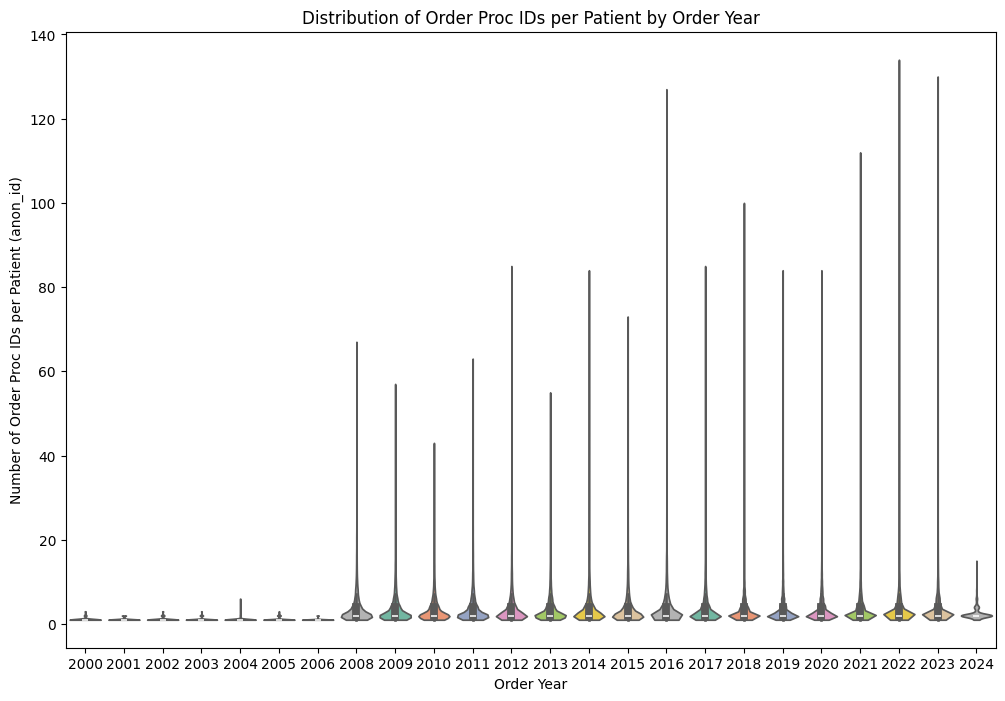

In [29]:
# Group by order_year and anon_id, and count unique order_proc_id_coded
grouped = Npatients_peryear.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

custom_palette = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
plt.title('Distribution of Order Proc IDs per Patient by Order Year')
plt.xlabel('Order Year')
plt.ylabel('Number of Order Proc IDs per Patient (anon_id)')
plt.savefig('1.png')
plt.show()


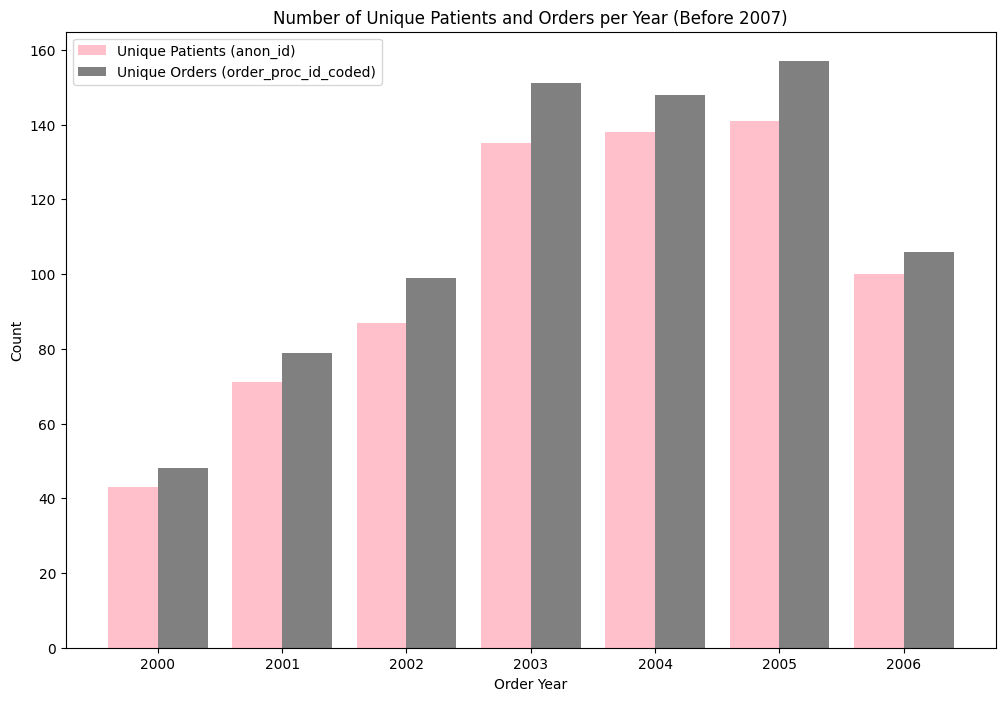

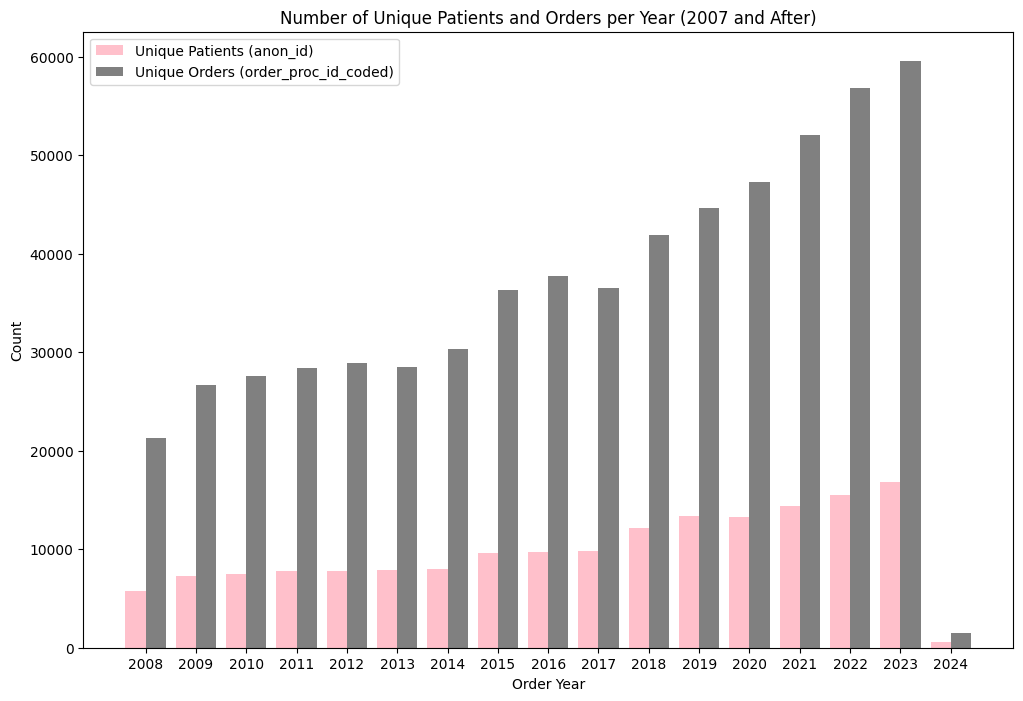

In [30]:
df_before_2009 = Npatients_peryear[Npatients_peryear['order_year'] < 2007]
df_after_2009 = Npatients_peryear[Npatients_peryear['order_year'] >= 2007]

# Calculate unique counts per year for both periods
unique_anon_id_before_2009 = df_before_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009 = df_before_2009.groupby('order_year')['order_proc_id_coded'].nunique()

unique_anon_id_after_2009 = df_after_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009 = df_after_2009.groupby('order_year')['order_proc_id_coded'].nunique()

# Create DataFrames for plotting
plot_df_before_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_before_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_before_2009
}).reset_index()

plot_df_after_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_after_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_after_2009
}).reset_index()

# Plotting before 2009
plt.figure(figsize=(12, 8))
bar_width = 0.4
years_before_2009 = plot_df_before_2009['order_year']
index_before_2009 = range(len(years_before_2009))

plt.bar(index_before_2009, plot_df_before_2009['Unique Patients (anon_id)'], bar_width, label='Unique Patients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded)', color='gray')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique Patients and Orders per Year (Before 2007)')
plt.xticks([i + bar_width / 2 for i in index_before_2009], years_before_2009)
plt.legend()
plt.savefig('1.png')
plt.show()

# Plotting after 2009
plt.figure(figsize=(12, 8))
bar_width = 0.4
years_after_2009 = plot_df_after_2009['order_year']
index_after_2009 = range(len(years_after_2009))

plt.bar(index_after_2009, plot_df_after_2009['Unique Patients (anon_id)'], bar_width, label='Unique Patients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded)', color='gray')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique Patients and Orders per Year (2007 and After)')
plt.xticks([i + bar_width / 2 for i in index_after_2009], years_after_2009)
plt.legend()
plt.savefig('2.png')
plt.show()

## How often do they grow anything?

In [31]:
%%bigquery df 
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
        op.order_proc_id_coded,
        op.order_time_jittered_utc,
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
        lr.ord_value,
        coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
    ) 
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%")
     AND not (upper(comment) like any ('%NO%GROWTH%'))

Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
Npatients_peryear_growth=df[['anon_id','order_year','order_proc_id_coded']]
Npatients_peryear_growth.drop_duplicates(inplace=True)

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_38179/3956615428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Npatients_peryear_growth.drop_duplicates(inplace=True)


/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_38179/1036133587.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_38179/1036133587.py:8: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)


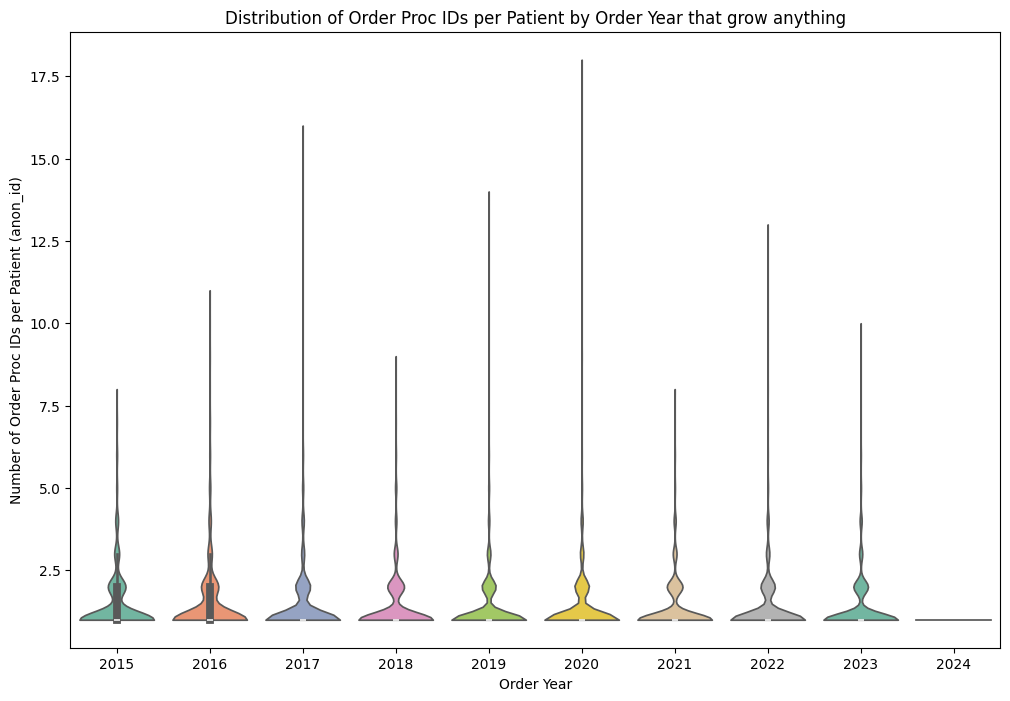

In [33]:
# Group by order_year and anon_id, and count unique order_proc_id_coded
grouped = Npatients_peryear_growth.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

custom_palette = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
plt.title('Distribution of Order Proc IDs per Patient by Order Year that grow anything')
plt.xlabel('Order Year')
plt.ylabel('Number of Order Proc IDs per Patient (anon_id)')
plt.savefig('1.png')
plt.show()

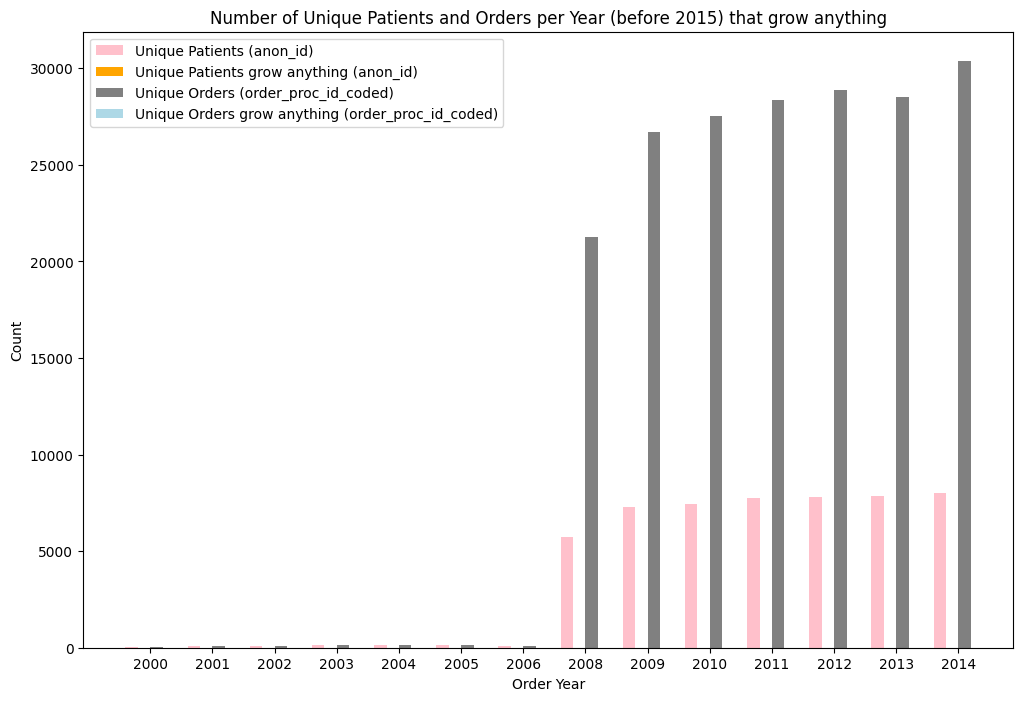

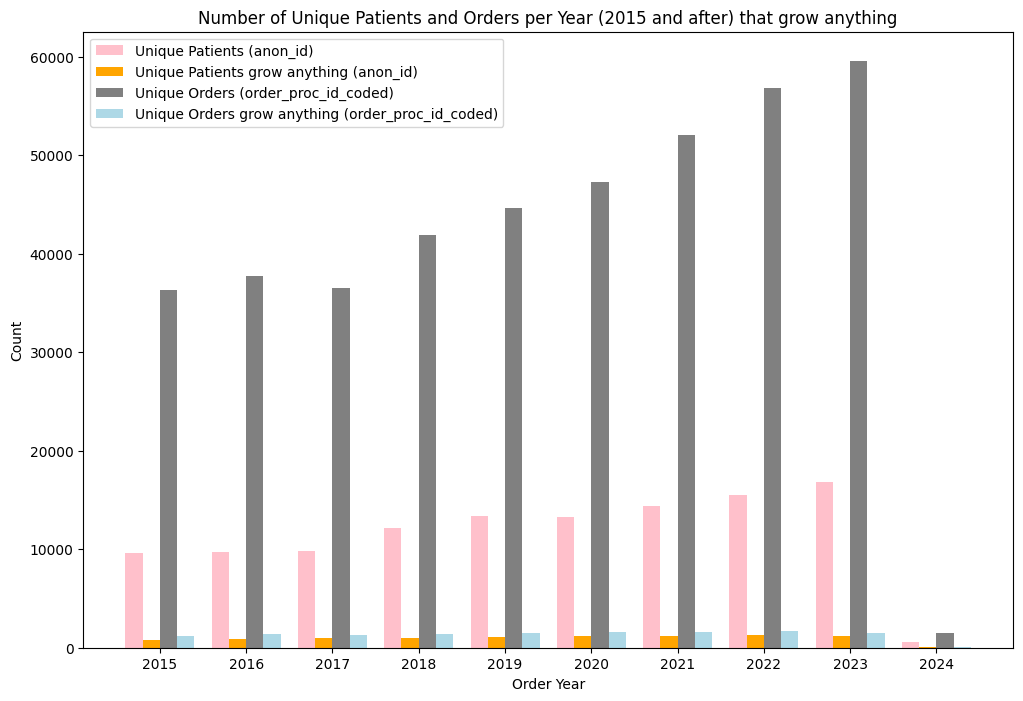

In [34]:
df_before_2009 = Npatients_peryear[Npatients_peryear['order_year'] < 2015]
df_after_2009 = Npatients_peryear[Npatients_peryear['order_year'] >= 2015]

df_before_2009_growth = Npatients_peryear_growth[Npatients_peryear_growth['order_year'] < 2015]
df_after_2009_growth = Npatients_peryear_growth[Npatients_peryear_growth['order_year'] >= 2015]


# Calculate unique counts per year for both periods
unique_anon_id_before_2009 = df_before_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009 = df_before_2009.groupby('order_year')['order_proc_id_coded'].nunique()
unique_anon_id_before_2009_growth = df_before_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009_growth = df_before_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()


unique_anon_id_after_2009 = df_after_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009 = df_after_2009.groupby('order_year')['order_proc_id_coded'].nunique()

unique_anon_id_after_2009_growth = df_after_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009_growth = df_after_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()



# Create DataFrames for plotting
plot_df_before_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_before_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_before_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_before_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_before_2009_growth
    
}).reset_index()

plot_df_after_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_after_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_after_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_after_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_after_2009_growth
}).reset_index()




# Plotting before 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_before_2009 = plot_df_before_2009['order_year']
index_before_2009 = range(len(years_before_2009))

plt.bar(index_before_2009, plot_df_before_2009['Unique Patients (anon_id)'], bar_width, label='Unique Patients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_before_2009], plot_df_before_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique Patients grow anything (anon_id)', color='orange')
plt.bar([i + 2*bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded)', color='gray')
plt.bar([i + 3*bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique Orders grow anything (order_proc_id_coded)', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique Patients and Orders per Year (before 2015) that grow anything')
plt.xticks([i + 1.5*bar_width for i in index_before_2009], years_before_2009)
plt.legend()
plt.show()

# Plotting after 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_after_2009 = plot_df_after_2009['order_year']
index_after_2009 = range(len(years_after_2009))

plt.bar(index_after_2009, plot_df_after_2009['Unique Patients (anon_id)'], bar_width, label='Unique Patients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_after_2009], plot_df_after_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique Patients grow anything (anon_id)', color='orange')
plt.bar([i + 2*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded)', color='gray')
plt.bar([i + 3*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique Orders grow anything (order_proc_id_coded)', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique Patients and Orders per Year (2015 and after) that grow anything')
plt.xticks([i + 1.5*bar_width for i in index_after_2009], years_after_2009)
plt.legend()
plt.savefig('1.png')
plt.show()

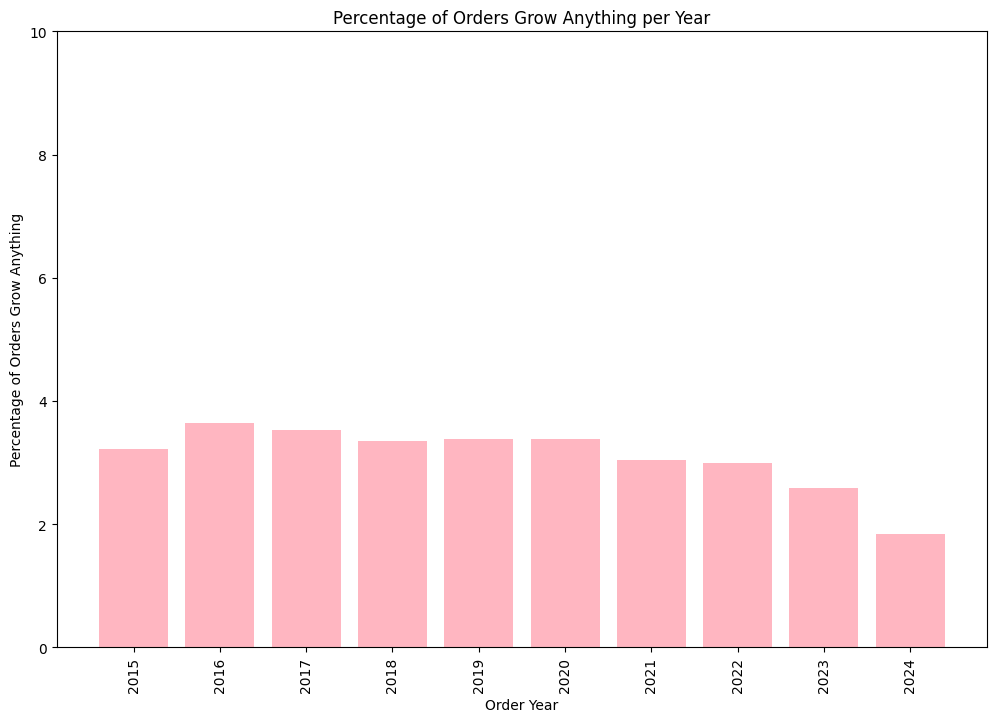

In [35]:

# Calculate total number of orders per year
Npatients_peryear2=Npatients_peryear[Npatients_peryear.order_year>=2015]
total_orders_per_year = Npatients_peryear2.groupby('order_year')['order_proc_id_coded'].count()

# Calculate number of orders with growth per year
orders_with_growth_per_year = Npatients_peryear_growth.groupby('order_year')['order_proc_id_coded'].count()

# Calculate percentage of orders with growth per year
percentage_growth_per_year = (orders_with_growth_per_year / total_orders_per_year) * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Total Orders': total_orders_per_year,
    'Orders with Growth': orders_with_growth_per_year,
    'Percentage Growth': percentage_growth_per_year
}).reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(plot_df['order_year'], plot_df['Percentage Growth'], color='lightpink')
plt.xlabel('Order Year')
plt.ylabel('Percentage of Orders Grow Anything')
plt.title('Percentage of Orders Grow Anything per Year')
plt.ylim(0, 10)  # Ensures the y-axis is in percentage
plt.xticks(plot_df['order_year'],rotation=90)
plt.savefig('1.png')
plt.show()

## How often do they grow anything that is not Coag Neg Staph or Gram + rods? (or other designation from the result comment that indicates contamination/not a real infection)

In [ ]:
if there is a  Coag Neg Staph and organism for now let's consider it as posetive cultures 
There is Nick genral rule for including or excluding cultures or consider them as posetive ones 

In [ ]:
%%bigquery df 
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
        op.order_proc_id_coded,
        op.order_time_jittered_utc,
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
        lr.ord_value,
        coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
    ) 
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))

In [ ]:
Npatients_peryear_growth=df[['anon_id','order_year','order_proc_id_coded']]
Npatients_peryear_growth.drop_duplicates(inplace=True)

In [ ]:
# Group by order_year and anon_id, and count unique order_proc_id_coded
grouped = Npatients_peryear_growth.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

custom_palette = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
plt.title('Distribution of Order Proc IDs per Patient by Order Year that Grow anything Except for GRAM + ROS and Coag Neg Staph.')
plt.xlabel('Order Year')
plt.ylabel('Number of Order Proc IDs per Patient (anon_id)')
plt.savefig('1.png')
plt.show()

In [ ]:
df_before_2009 = Npatients_peryear[Npatients_peryear['order_year'] < 2015]
df_after_2009 = Npatients_peryear[Npatients_peryear['order_year'] >= 2015]

df_before_2009_growth = Npatients_peryear_growth[Npatients_peryear_growth['order_year'] < 2015]
df_after_2009_growth = Npatients_peryear_growth[Npatients_peryear_growth['order_year'] >= 2015]


# Calculate unique counts per year for both periods
unique_anon_id_before_2009 = df_before_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009 = df_before_2009.groupby('order_year')['order_proc_id_coded'].nunique()
unique_anon_id_before_2009_growth = df_before_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009_growth = df_before_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()


unique_anon_id_after_2009 = df_after_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009 = df_after_2009.groupby('order_year')['order_proc_id_coded'].nunique()

unique_anon_id_after_2009_growth = df_after_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009_growth = df_after_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()



# Create DataFrames for plotting
plot_df_before_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_before_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_before_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_before_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_before_2009_growth
    
}).reset_index()

plot_df_after_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_after_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_after_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_after_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_after_2009_growth
}).reset_index()

# Plotting after 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_after_2009 = plot_df_after_2009['order_year']
index_after_2009 = range(len(years_after_2009))

plt.bar(index_after_2009, plot_df_after_2009['Unique Patients (anon_id)'], bar_width, label='Unique Patients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_after_2009], plot_df_after_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique Patients grow anything (anon_id)', color='orange')
plt.bar([i + 2*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded)', color='gray')
plt.bar([i + 3*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique Orders grow anything (order_proc_id_coded)', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique Patients and Orders per Year (2015 and After) that Grow anything Except for GRAM + ROS and Coag Neg Staph.')
plt.xticks([i + 1.5*bar_width for i in index_after_2009], years_after_2009)
plt.legend()
plt.savefig('1.png')
plt.show()

In [ ]:
# Calculate total number of orders per year
Npatients_peryear2=Npatients_peryear[Npatients_peryear.order_year>=2015]
total_orders_per_year = Npatients_peryear2.groupby('order_year')['order_proc_id_coded'].count()

# Calculate number of orders with growth per year
orders_with_growth_per_year = Npatients_peryear_growth.groupby('order_year')['order_proc_id_coded'].count()

# Calculate percentage of orders with growth per year
percentage_growth_per_year = (orders_with_growth_per_year / total_orders_per_year) * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Total Orders': total_orders_per_year,
    'Orders with Growth': orders_with_growth_per_year,
    'Percentage Growth': percentage_growth_per_year
}).reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(plot_df['order_year'], plot_df['Percentage Growth'], color='lightpink')
plt.xlabel('Order Year')
plt.ylabel('Percentage of Orders Grow Anything')
plt.title('Percentage of Orders Grow Anything per Year')
plt.ylim(0, 10)  # Ensures the y-axis is in percentage
plt.xticks(plot_df['order_year'],rotation=90)
plt.savefig('1.png')
plt.show()

In [ ]:
%%bigquery df1
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
        op.order_proc_id_coded,
        op.order_time_jittered_utc,
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
        lr.ord_value,
        coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
    ) 
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%')) 

In [ ]:
%%bigquery df2
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
        op.order_proc_id_coded,
        op.order_time_jittered_utc,
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
        lr.ord_value,
        coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
    ) 
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%")
     AND not (upper(comment) like any ('%NO%GROWTH%'))


In [ ]:
df1=df1[['anon_id','order_proc_id_coded','order_year']]
df2=df2[['anon_id','order_proc_id_coded','order_year']]
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)

In [ ]:
df2[(~df2.anon_id.isin(df1.anon_id.unique()))&(~df2.order_proc_id_coded.isin(df1.order_proc_id_coded.unique()))]

In [ ]:
df3=df2[df2.comment.str.contains('contamin')][['comment']]
df3.reset_index(inplace=True)
df3.iloc[4].comment

In [ ]:
df1

In [ ]:
# Merge DataFrames to find orders in df1 that are also in df2
merged_df = df1.merge(df2, on=['anon_id', 'order_proc_id_coded', 'order_year'], how='inner')

# Count the number of unique orders per year in df1 and those also in df2
total_orders_per_year = df2.groupby('order_year')['order_proc_id_coded'].count()
orders_in_both_per_year = merged_df.groupby('order_year')['order_proc_id_coded'].count()

# Calculate percentage of orders in df1 that are also in df2
percentage_in_both_per_year = (orders_in_both_per_year / total_orders_per_year) * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'order_year': percentage_in_both_per_year.index,
    'percentage_in_both': 100-percentage_in_both_per_year.values
})

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(plot_df['order_year'], plot_df['percentage_in_both'], color='skyblue')
plt.xlabel('Order Year')
plt.ylabel('Percentage of Orders that Grow Anything but Contaminated')
plt.title('Percentage of Orders that Grow Anything but Contaminated Per Year')
plt.xticks(plot_df['order_year'], rotation=90)
plt.ylim(0, 5)  # Ensures the y-axis is in percentage
plt.savefig('1.png')
plt.show()


# Ordered in Emergency Department (ED) vs. Inpatient (in hospital)

## How many blood cultures ordered for how many patients (per year)?

In [ ]:
%%bigquery df_ED
with base as (
SELECT DISTINCT
        op.anon_id, 
        op.order_proc_id_coded, 
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year ,  
        op.ordering_mode,
        op.department_id,
    
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
     INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
)
select b.anon_id,b.order_proc_id_coded,b.order_year,b.ordering_mode,department_name
from base b inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.ordering_mode,department_name

In [ ]:
%%bigquery df_Inpatient
with base as (
SELECT DISTINCT
        op.anon_id, 
        op.order_proc_id_coded, 
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year ,  
        op.ordering_mode,
        op.department_id,
    
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
     INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
)
select b.anon_id,b.order_proc_id_coded,b.order_year,b.ordering_mode,department_name
from base b inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where ordering_mode='Inpatient'
and not lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.ordering_mode,department_name

In [ ]:
Npatients_peryear_IN=df_Inpatient[['anon_id','order_year','order_proc_id_coded']]
Npatients_peryear_IN.drop_duplicates(inplace=True)

Npatients_peryear_ED=df_ED[['anon_id','order_year','order_proc_id_coded']]
Npatients_peryear_ED.drop_duplicates(inplace=True)

In [ ]:
# Group by order_year and anon_id, and count unique order_proc_id_coded
grouped_IN = Npatients_peryear_IN.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')
grouped_ED = Npatients_peryear_ED.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

# Sum the counts per year
sum_IN = grouped_IN.groupby('order_year')['proc_id_count'].sum().reset_index(name='count_IN')
sum_ED = grouped_ED.groupby('order_year')['proc_id_count'].sum().reset_index(name='count_ED')

# Merge the two dataframes on order_year
merged = pd.merge(sum_IN, sum_ED, on='order_year', how='outer').fillna(0)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.6

plt.bar(merged['order_year'], merged['count_ED'], bar_width, label='ED', color='skyblue')
plt.bar(merged['order_year'], merged['count_IN'], bar_width, bottom=merged['count_ED'], label='Inpatient', color='lightcoral')

plt.xlabel('Order Year')
plt.ylabel('Number of Unique Orders')
plt.title('Number of Unique Orders per Year (Stacked: ED and Inpatient)')
plt.xticks(merged['order_year'])
plt.legend()
plt.savefig('1.png')
plt.show()

In [ ]:
df_before_2009 = Npatients_peryear_ED[Npatients_peryear_ED['order_year'] < 2015]
df_after_2009 = Npatients_peryear_ED[Npatients_peryear_ED['order_year'] >= 2015]

df_before_2009_growth = Npatients_peryear_IN[Npatients_peryear_IN['order_year'] < 2015]
df_after_2009_growth = Npatients_peryear_IN[Npatients_peryear_IN['order_year'] >= 2015]


# Calculate unique counts per year for <2015 for both ED and IN
unique_anon_id_before_2009 = df_before_2009.groupby('order_year')['anon_id'].nunique()#ED
unique_order_proc_id_coded_before_2009 = df_before_2009.groupby('order_year')['order_proc_id_coded'].nunique()#ED
unique_anon_id_before_2009_growth = df_before_2009_growth.groupby('order_year')['anon_id'].nunique()#IN
unique_order_proc_id_coded_before_2009_growth = df_before_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()#IN

# Calculate unique counts per year for >2015 for both ED and IN
unique_anon_id_after_2009 = df_after_2009.groupby('order_year')['anon_id'].nunique()#ED
unique_order_proc_id_coded_after_2009 = df_after_2009.groupby('order_year')['order_proc_id_coded'].nunique()#ED
unique_anon_id_after_2009_growth = df_after_2009_growth.groupby('order_year')['anon_id'].nunique()#IN
unique_order_proc_id_coded_after_2009_growth = df_after_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()#IN



# Create DataFrames for plotting
plot_df_before_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_before_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_before_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_before_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_before_2009_growth
    
}).reset_index()

plot_df_after_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_after_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_after_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_after_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_after_2009_growth
}).reset_index()

# Plotting before 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_before_2009 = plot_df_before_2009['order_year']
index_before_2009 = range(len(years_before_2009))

plt.bar(index_before_2009, plot_df_before_2009['Unique Patients (anon_id)'], bar_width, label='Unique ED Patients (anon_id) with culture order', color='pink')
plt.bar([i + bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded) for ED patients', color='gray')
plt.bar([i + 2*bar_width for i in index_before_2009], plot_df_before_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique Inpatient Patients with culture order (anon_id)', color='orange')
plt.bar([i + 3*bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded) for Inpatients', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique ED Patients and Orders VS Inpatients per Year (before 2015)')
plt.xticks([i + 1.5*bar_width for i in index_before_2009], years_before_2009)
plt.legend()
plt.show()


# Plotting after 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_after_2009 = plot_df_after_2009['order_year']
index_after_2009 = range(len(years_after_2009))

plt.bar(index_after_2009, plot_df_after_2009['Unique Patients (anon_id)'], bar_width, label='Unique ED Patients (anon_id) with culture order', color='pink')
plt.bar([i + bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded) for ED patients', color='gray')
plt.bar([i + 2*bar_width for i in index_after_2009], plot_df_after_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique Inpatient Patients with culture order (anon_id)', color='orange')
plt.bar([i + 3*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique Orders (order_proc_id_coded) for Inpatients', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique ED Patients and Orders VS Inpatients per Year (2015 and After)')
plt.xticks([i + 1.5*bar_width for i in index_after_2009], years_after_2009)
plt.legend()
plt.savefig('1.png')
plt.show()

## How often do they grow anything?

In [ ]:
%%bigquery df_ed_growth
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
    ),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
department_name
from culutre_grow b inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,department_name

In [ ]:
%%bigquery df_in_growth
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
    ),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
department_name
from culutre_grow b inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where not lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,department_name

In [ ]:
Npatients_peryear_ed_growth=df_ed_growth[['anon_id','order_year','order_proc_id_coded']]
Npatients_peryear_ed_growth.drop_duplicates(inplace=True)

Npatients_peryear_in_growth=df_in_growth[['anon_id','order_year','order_proc_id_coded']]
Npatients_peryear_in_growth.drop_duplicates(inplace=True)

In [ ]:
# Group by order_year and anon_id, and count unique order_proc_id_coded
grouped = Npatients_peryear_ED.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

custom_palette = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
plt.title('Distribution of Order Proc IDs per Patient by Order Year in ED')
plt.xlabel('Order Year')
plt.ylabel('Number of Order Proc IDs per Patient (anon_id)')
plt.savefig('2.png')
plt.show()



grouped = Npatients_peryear_ed_growth.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

custom_palette = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
plt.title('Distribution of Order Proc IDs per Patient by Order Year in ED that grow any thing')
plt.xlabel('Order Year')
plt.ylabel('Number of Order Proc IDs per Patient (anon_id)')
plt.savefig('1.png')
plt.show()

In [ ]:
# Group by order_year and anon_id, and count unique order_proc_id_coded
grouped = Npatients_peryear_IN.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

custom_palette = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
plt.title('Distribution of Order Proc IDs per Patient by Order Year Inpatients')
plt.xlabel('Order Year')
plt.ylabel('Number of Order Proc IDs per Patient (anon_id)')
plt.savefig('1.png')
plt.show()



grouped = Npatients_peryear_in_growth.groupby(['order_year', 'anon_id']).order_proc_id_coded.nunique().reset_index(name='proc_id_count')

custom_palette = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='order_year', y='proc_id_count', data=grouped, palette=custom_palette, cut=0)
plt.title('Distribution of Order Proc IDs per Inpatients Patient by Order Year that grow any thing')
plt.xlabel('Order Year')
plt.ylabel('Number of Order Proc IDs per Patient (anon_id)')
plt.savefig('2.png')
plt.show()

In [ ]:
df_before_2009 = Npatients_peryear_ED[Npatients_peryear_ED['order_year'] < 2015]
df_after_2009 = Npatients_peryear_ED[Npatients_peryear_ED['order_year'] >= 2015]

df_before_2009_growth = Npatients_peryear_ed_growth[Npatients_peryear_ed_growth['order_year'] < 2015]
df_after_2009_growth = Npatients_peryear_ed_growth[Npatients_peryear_ed_growth['order_year'] >= 2015]


# Calculate unique counts per year for both periods
unique_anon_id_before_2009 = df_before_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009 = df_before_2009.groupby('order_year')['order_proc_id_coded'].nunique()
unique_anon_id_before_2009_growth = df_before_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009_growth = df_before_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()


unique_anon_id_after_2009 = df_after_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009 = df_after_2009.groupby('order_year')['order_proc_id_coded'].nunique()

unique_anon_id_after_2009_growth = df_after_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009_growth = df_after_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()



# Create DataFrames for plotting
plot_df_before_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_before_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_before_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_before_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_before_2009_growth
    
}).reset_index()

plot_df_after_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_after_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_after_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_after_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_after_2009_growth
}).reset_index()




# Plotting before 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_before_2009 = plot_df_before_2009['order_year']
index_before_2009 = range(len(years_before_2009))

plt.bar(index_before_2009, plot_df_before_2009['Unique Patients (anon_id)'], bar_width, label='Unique Patients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_before_2009], plot_df_before_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique ED Patients grow anything (anon_id)', color='orange')
plt.bar([i + 2*bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique ED Orders (order_proc_id_coded)', color='gray')
plt.bar([i + 3*bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique ED Orders grow anything (order_proc_id_coded)', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique ED Patients and Orders per Year (before 2015) that grow anything ')
plt.xticks([i + 1.5*bar_width for i in index_before_2009], years_before_2009)
plt.legend()
plt.show()

# Plotting after 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_after_2009 = plot_df_after_2009['order_year']
index_after_2009 = range(len(years_after_2009))

plt.bar(index_after_2009, plot_df_after_2009['Unique Patients (anon_id)'], bar_width, label='Unique Patients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_after_2009], plot_df_after_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique ED Patients grow anything (anon_id)', color='orange')
plt.bar([i + 2*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique ED Orders (order_proc_id_coded)', color='gray')
plt.bar([i + 3*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique ED Orders grow anything (order_proc_id_coded)', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique ED Patients and Orders per Year (2015 and after) that grow anything')
plt.xticks([i + 1.5*bar_width for i in index_after_2009], years_after_2009)
plt.legend()
plt.savefig('1.png')
plt.show()

In [ ]:
df_before_2009 = Npatients_peryear_IN[Npatients_peryear_IN['order_year'] < 2015]
df_after_2009 = Npatients_peryear_IN[Npatients_peryear_IN['order_year'] >= 2015]

df_before_2009_growth = Npatients_peryear_in_growth[Npatients_peryear_in_growth['order_year'] < 2015]
df_after_2009_growth = Npatients_peryear_in_growth[Npatients_peryear_in_growth['order_year'] >= 2015]


# Calculate unique counts per year for both periods
unique_anon_id_before_2009 = df_before_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009 = df_before_2009.groupby('order_year')['order_proc_id_coded'].nunique()
unique_anon_id_before_2009_growth = df_before_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_before_2009_growth = df_before_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()


unique_anon_id_after_2009 = df_after_2009.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009 = df_after_2009.groupby('order_year')['order_proc_id_coded'].nunique()

unique_anon_id_after_2009_growth = df_after_2009_growth.groupby('order_year')['anon_id'].nunique()
unique_order_proc_id_coded_after_2009_growth = df_after_2009_growth.groupby('order_year')['order_proc_id_coded'].nunique()



# Create DataFrames for plotting
plot_df_before_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_before_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_before_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_before_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_before_2009_growth
    
}).reset_index()

plot_df_after_2009 = pd.DataFrame({
    'Unique Patients (anon_id)': unique_anon_id_after_2009,
    'Unique Procedures (order_proc_id_coded)': unique_order_proc_id_coded_after_2009,
    'Unique Patients growth (anon_id)': unique_anon_id_after_2009_growth,
    'Unique Procedures growth (order_proc_id_coded)': unique_order_proc_id_coded_after_2009_growth
}).reset_index()




# Plotting before 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_before_2009 = plot_df_before_2009['order_year']
index_before_2009 = range(len(years_before_2009))

plt.bar(index_before_2009, plot_df_before_2009['Unique Patients (anon_id)'], bar_width, label='Unique Inpatients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_before_2009], plot_df_before_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique Inpatients grow anything (anon_id)', color='orange')
plt.bar([i + 2*bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Inpatients Orders (order_proc_id_coded)', color='gray')
plt.bar([i + 3*bar_width for i in index_before_2009], plot_df_before_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique Inpatients Orders grow anything (order_proc_id_coded)', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique Inpatients and Orders per Year (before 2015) that grow anything ')
plt.xticks([i + 1.5*bar_width for i in index_before_2009], years_before_2009)
plt.legend()
plt.show()

# Plotting after 2009
plt.figure(figsize=(12, 8))
bar_width = 0.2
years_after_2009 = plot_df_after_2009['order_year']
index_after_2009 = range(len(years_after_2009))

plt.bar(index_after_2009, plot_df_after_2009['Unique Patients (anon_id)'], bar_width, label='Unique Inpatients (anon_id)', color='pink')
plt.bar([i + bar_width for i in index_after_2009], plot_df_after_2009['Unique Patients growth (anon_id)'], bar_width, label='Unique Inpatients grow anything (anon_id)', color='orange')
plt.bar([i + 2*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures (order_proc_id_coded)'], bar_width, label='Unique Inpatients Orders (order_proc_id_coded)', color='gray')
plt.bar([i + 3*bar_width for i in index_after_2009], plot_df_after_2009['Unique Procedures growth (order_proc_id_coded)'], bar_width, label='Unique Inpatients Orders grow anything (order_proc_id_coded)', color='lightblue')

plt.xlabel('Order Year')
plt.ylabel('Count')
plt.title('Number of Unique Inpatients and Orders per Year (2015 and after) that grow anything')
plt.xticks([i + 1.5*bar_width for i in index_after_2009], years_after_2009)
plt.legend()
plt.savefig('1.png')
plt.show()

In [ ]:

# Calculate total number of orders per year
Npatients_peryear2=Npatients_peryear_ED[Npatients_peryear_ED.order_year>=2015]
total_orders_per_year = Npatients_peryear2.groupby('order_year')['order_proc_id_coded'].count()

# Calculate number of orders with growth per year
orders_with_growth_per_year = Npatients_peryear_ed_growth.groupby('order_year')['order_proc_id_coded'].count()

# Calculate percentage of orders with growth per year
percentage_growth_per_year = (orders_with_growth_per_year / total_orders_per_year) * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Total Orders': total_orders_per_year,
    'Orders with Growth': orders_with_growth_per_year,
    'Percentage Growth': percentage_growth_per_year
}).reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(plot_df['order_year'], plot_df['Percentage Growth'], color='lightpink')
plt.xlabel('Order Year')
plt.ylabel('Percentage of ED Orders Grow Anything')
plt.title('Percentage of ED Orders Grow Anything per Year')
plt.ylim(0, 10)  # Ensures the y-axis is in percentage
plt.xticks(plot_df['order_year'],rotation=90)
plt.savefig('1.png')
plt.show()

In [ ]:

# Calculate total number of orders per year
Npatients_peryear2=Npatients_peryear_IN[Npatients_peryear_IN.order_year>=2015]
total_orders_per_year = Npatients_peryear2.groupby('order_year')['order_proc_id_coded'].count()

# Calculate number of orders with growth per year
orders_with_growth_per_year = Npatients_peryear_in_growth.groupby('order_year')['order_proc_id_coded'].count()

# Calculate percentage of orders with growth per year
percentage_growth_per_year = (orders_with_growth_per_year / total_orders_per_year) * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Total Orders': total_orders_per_year,
    'Orders with Growth': orders_with_growth_per_year,
    'Percentage Growth': percentage_growth_per_year
}).reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(plot_df['order_year'], plot_df['Percentage Growth'], color='lightpink')
plt.xlabel('Order Year')
plt.ylabel('Percentage of Inpatients Orders Grow Anything')
plt.title('Percentage of Inpatients Orders Grow Anything per Year')
plt.ylim(0, 10)  # Ensures the y-axis is in percentage
plt.xticks(plot_df['order_year'],rotation=90)
plt.show()

## Patient arrival in ED until time of culture

In [ ]:
%%bigquery df_ED
with base as (
SELECT DISTINCT
        op.anon_id, 
        op.order_proc_id_coded, 
        op.pat_enc_csn_id_coded,
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year ,
        op.order_time_jittered_utc,
        op.department_id,
    
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
     INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
ED_orders as (
select b.anon_id,
b.order_proc_id_coded,
b.pat_enc_csn_id_coded,
b.order_year,
b.order_time_jittered_utc,
department_id,
from base b inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.pat_enc_csn_id_coded,b.order_year,b.order_time_jittered_utc,b.department_id
)
SELECT 
  b.anon_id,
  b.order_proc_id_coded,
  b.order_year,
  b.pat_enc_csn_id_coded,
  MIN(TIMESTAMP_DIFF(b.order_time_jittered_utc,ad.effective_time_jittered_utc, Hour)) AS time_diff_hours,
 MIN(TIMESTAMP_DIFF(b.order_time_jittered_utc,ad.effective_time_jittered_utc, Minute)) AS time_diff_min
FROM 
  ED_orders b
INNER JOIN 
  `som-nero-phi-jonc101.shc_core_2023.adt` ad
USING 
  (anon_id,pat_enc_csn_id_coded,department_id)
Where event_type='Admission'
and b.order_time_jittered_utc>=ad.effective_time_jittered_utc
GROUP BY 
  anon_id, order_proc_id_coded, order_year,pat_enc_csn_id_coded

In [ ]:
df_ED=df_ED[df_ED.time_diff_hours<=72]

In [ ]:
df_ED1=df_ED
#Plotting the distribution of time_diff_hours per order_year
plt.figure(figsize=(10, 6))

for year in df_ED1['order_year'].unique():
    subset = df_ED1[df_ED1['order_year'] == year]
    subset['time_diff_hours'].plot(kind='kde', label=f'Year {year}')

plt.title('Distribution of Time Difference in Hours from Arrival in ED to Culture Order per Year')
plt.xlabel('Time Difference in Hours')
plt.xlim(-10,20)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.grid(True)
plt.savefig('1.png')
plt.show()

In [ ]:
df_ED=df_ED[df_ED.time_diff_min<=(72*60)]

In [ ]:
df_ED1=df_ED
plt.figure(figsize=(10, 6))

for year in df_ED1['order_year'].unique():
    subset = df_ED1[df_ED1['order_year'] == year]
    subset['time_diff_min'].plot(kind='kde', label=f'Year {year}')

plt.title('Distribution of Time Difference in Minutes from Arrival in ED to Culture Order per Year')
plt.xlabel('Time Difference in Minutes')
plt.xlim(-100,400)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.grid(True)
plt.savefig('1.png')
plt.show()

In [ ]:
# Plotting the average time_diff_hours per order_year as a bar chart
avg_time_diff_per_year = df_ED.groupby('order_year')['time_diff_hours'].mean()

plt.figure(figsize=(10, 6))
avg_time_diff_per_year.plot(kind='bar', color='skyblue')

plt.title('Average Time Difference in Hours per Order Year')
plt.xlabel('Order Year')
plt.ylabel('Average Time Difference in Hours for ED patients')
plt.grid(axis='y')
plt.savefig('1.png')
plt.show()

In [ ]:
# Plotting the average time_diff_hours per order_year as a bar chart
avg_time_diff_per_year = df_ED.groupby('order_year')['time_diff_min'].median()

plt.figure(figsize=(10, 6))
avg_time_diff_per_year.plot(kind='bar', color='skyblue')

plt.title('Median Time Difference in Minutes per Order Year')
plt.xlabel('Order Year')
plt.ylabel('Median Time Difference in Minutes for ED patients')
plt.grid(axis='y')
plt.show()

## ED cultures until (IV) Antibiotic order time

In [ ]:
%%bigquery df_ED_ABX
with base as (
SELECT DISTINCT
        op.anon_id, 
        op.order_proc_id_coded,
        op.pat_enc_csn_id_coded,
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year ,
        op.order_time_jittered_utc,
        op.department_id,
    
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
     INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
ED_orders as (
select b.anon_id,
b.order_proc_id_coded,
b.pat_enc_csn_id_coded,
b.order_year,
b.order_time_jittered_utc,
from base b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.pat_enc_csn_id_coded,b.order_year,department_name,b.order_time_jittered_utc
),
ED_ABX as (
     select b.anon_id,
     b.pat_enc_csn_id_coded,
     b.order_proc_id_coded,
     b.order_year,
     b.order_time_jittered_utc,
     o.order_start_time_jittered_utc,
     TIMESTAMP_DIFF(o.order_start_time_jittered_utc,b.order_time_jittered_utc, Hour) AS time_diff_hours,
     TIMESTAMP_DIFF(o.order_start_time_jittered_utc,b.order_time_jittered_utc, Minute) AS time_diff_min,
     o.med_description,
 from ED_orders b
left join `som-nero-phi-jonc101.shc_core_2023.order_med` o using(anon_id,pat_enc_csn_id_coded)
 where  o.thera_class_name in ('ANTIBIOTICS')
and lower(o.med_route) in ('intravenous')
)
select m.anon_id,
m.pat_enc_csn_id_coded,
m.order_proc_id_coded,
m.time_diff_hours,
m.time_diff_min,
m.order_year,
mm.rxcui_str
from ED_ABX m 
inner join `som-nero-phi-jonc101.shc_core_2023.mapped_meds` mm on m.med_description=mm.name
where not rxcui='0'
group by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_year,time_diff_hours,time_diff_min,rxcui_str


In [ ]:
df_ED1=df_ED_ABX
#Plotting the distribution of time_diff_hours per order_year
plt.figure(figsize=(10, 6))

for year in df_ED1['order_year'].unique():
    subset = df_ED1[df_ED1['order_year'] == year]
    subset['time_diff_hours'].plot(kind='kde', label=f'Year {year}')

plt.title('Distribution of Time Difference in Hours from Culture Order to Recive ABX per Year')
plt.xlabel('Time Difference in Hours')
plt.xlim(-50,150)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.grid(True)
plt.savefig('1.png')
plt.show()

In [ ]:
df_ED1=df_ED_ABX
#Plotting the distribution of time_diff_hours per order_year
plt.figure(figsize=(10, 6))

for year in df_ED1['order_year'].unique():
    subset = df_ED1[df_ED1['order_year'] == year]
    subset['time_diff_min'].plot(kind='kde', label=f'Year {year}')

plt.title('Distribution of Time to ABX in Minutes from Culture Order per Year for ED patients')
plt.xlabel('Time Difference in Minutes')
plt.xlim(-2000,4000)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.grid(True)
plt.savefig('1.png')
plt.show()

In [ ]:
# Plotting the average time_diff_hours per order_year as a bar chart
avg_time_diff_per_year = df_ED_ABX.groupby('order_year')['time_diff_hours'].median()

plt.figure(figsize=(10, 6))
avg_time_diff_per_year.plot(kind='bar', color='skyblue')

plt.title('Median Time to ABX in Hours per Year for ED patients')
plt.xlabel('Order Year')
plt.ylabel('Median Time to ABX in Hours')
plt.grid(axis='y')
plt.savefig('1.png')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
# After 2017
df_ED_ABX2017=df_ED_ABX[df_ED_ABX.order_year>=2015]
# Find the top 20 most frequent ABX (rxcui_str)
top_abx = df_ED_ABX2017['rxcui_str'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top 20 most frequent ABX
df_top_abx = df_ED_ABX2017[df_ED_ABX2017['rxcui_str'].isin(top_abx)]

# Convert rxcui_str to numerical values using LabelEncoder
le = LabelEncoder()
df_top_abx['rxcui_str_encoded'] = le.fit_transform(df_top_abx['rxcui_str'])

# Plotting the KDE distributions
plt.figure(figsize=(15, 10))
for year in df_top_abx['order_year'].unique():
    subset = df_top_abx[df_top_abx['order_year'] == year]
    sns.kdeplot(data=subset, x='rxcui_str_encoded', label=f'Year {year}')

# Set x-ticks to show the ABX names
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=90)
plt.title('KDE Distributions of Top 20 Most Frequent ABX per Year(After 2014)')
plt.xlabel('ABX (rxcui_str)')
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.grid(True)
plt.savefig('1.png')
plt.show()



# Plotting the KDE distributions
df_ED_ABX=df_ED_ABX[df_ED_ABX.order_year<2017]
# Find the top 20 most frequent ABX (rxcui_str)
top_abx = df_ED_ABX['rxcui_str'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top 20 most frequent ABX
df_top_abx = df_ED_ABX[df_ED_ABX['rxcui_str'].isin(top_abx)]

# Convert rxcui_str to numerical values using LabelEncoder
le = LabelEncoder()
df_top_abx['rxcui_str_encoded'] = le.fit_transform(df_top_abx['rxcui_str'])

plt.figure(figsize=(15, 10))
for year in df_top_abx['order_year'].unique():
    subset = df_top_abx[df_top_abx['order_year'] == year]
    sns.kdeplot(data=subset, x='rxcui_str_encoded', label=f'Year {year}')

# Set x-ticks to show the ABX names
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=90)
plt.title('KDE Distributions of Top 20 Most Frequent ABX per Year(2016 and Before)')
plt.xlabel('ABX (rxcui_str)')
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.grid(True)

plt.show()

## WBC

### WBC for positive culutres orders

In [ ]:
%%bigquery df_ed_cult_pos_wbc
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as wbc
from ed_cult_pos b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lr.lab_name='WBC'

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_pos_wbc['wbc'] = pd.to_numeric(df_ed_cult_pos_wbc['wbc'], errors='coerce')
df_ed_cult_pos_wbc

In [ ]:
from scipy.stats import kruskal



# median of WBC per year
Median=df_ed_cult_pos_wbc[df_ed_cult_pos_wbc.wbc.notna()].groupby('order_year')['wbc'].median()

df_ed_cult_pos_wbc = df_ed_cult_pos_wbc.dropna(subset=['wbc'])


# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_pos_wbc['order_year'].unique()
groups = [df_ed_cult_pos_wbc[df_ed_cult_pos_wbc['order_year'] == year]['wbc'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_pos_wbc, x='wbc', hue='order_year', element="step")
plt.title(f'Distribution of WBC Values for ED patients with + culture orders by Year. p-value:{formatted_p_value}')
plt.xlabel('WBC')
plt.xlim(0,100)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()



In [ ]:
# etermine which specific years are significantly different
!pip install scikit-posthocs

In [ ]:
import scikit_posthocs as sp

df_ed_cult_pos_wbc = df_ed_cult_pos_wbc.dropna(subset=['wbc'])

# Calculate the median
Median = df_ed_cult_pos_wbc.groupby('order_year')['wbc'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [0,5,10,20,30,40,50,60]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_pos_wbc['wbc_bins'] = pd.cut(df_ed_cult_pos_wbc['wbc'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_pos_wbc.groupby(['order_year', 'wbc_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of WBC Values by Year for ED patients with + culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='WBC Range')
plt.savefig('1.png')
plt.show()

# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_pos_wbc['order_year'].unique()
groups = [df_ed_cult_pos_wbc[df_ed_cult_pos_wbc['order_year'] == year]['wbc'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')

# Perform Dunn's test for pairwise comparisons
p_values = sp.posthoc_dunn(df_ed_cult_pos_wbc, val_col='wbc', group_col='order_year', p_adjust='bonferroni')

# Filter and display pairs with p-values less than 1e-3
significant_pairs = p_values[p_values < 1e-3]
print("Significant pairs with p-values < 1e-3:")
print(significant_pairs)


### WBC for NEG culutres orders

In [ ]:
%%bigquery df_ed_cult_neg_wbc
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as wbc
from ed_cult_neg b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lr.lab_name='WBC'

In [ ]:
df_ed_cult_neg_wbc[df_ed_cult_neg_wbc.wbc.notna()].anon_id.nunique()

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_neg_wbc['wbc'] = pd.to_numeric(df_ed_cult_neg_wbc['wbc'], errors='coerce')
df_ed_cult_neg_wbc

In [ ]:
from scipy.stats import kruskal


# median of WBC per year
Median=df_ed_cult_neg_wbc[df_ed_cult_neg_wbc.wbc.notna()].groupby('order_year')['wbc'].median()

df_ed_cult_neg_wbc = df_ed_cult_neg_wbc.dropna(subset=['wbc'])

# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_neg_wbc['order_year'].unique()
groups = [df_ed_cult_neg_wbc[df_ed_cult_neg_wbc['order_year'] == year]['wbc'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_neg_wbc, x='wbc', hue='order_year', element="step")
plt.title(f'Distribution of WBC Values by Year for ED patients with - culture orders. p-value:{formatted_p_value}')
plt.xlabel('WBC')
plt.xlim(0,100)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()



In [ ]:
import scikit_posthocs as sp

df_ed_cult_neg_wbc = df_ed_cult_neg_wbc.dropna(subset=['wbc'])

# Calculate the median
Median = df_ed_cult_neg_wbc.groupby('order_year')['wbc'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [0,5,10,20,30,40,50,60]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_neg_wbc['wbc_bins'] = pd.cut(df_ed_cult_neg_wbc['wbc'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_neg_wbc.groupby(['order_year', 'wbc_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of WBC Values by Year for ED patients with - culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='WBC Range')
plt.savefig('1.png')
plt.show()

# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_neg_wbc['order_year'].unique()
groups = [df_ed_cult_neg_wbc[df_ed_cult_neg_wbc['order_year'] == year]['wbc'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')

# Perform Dunn's test for pairwise comparisons
p_values = sp.posthoc_dunn(df_ed_cult_neg_wbc, val_col='wbc', group_col='order_year', p_adjust='bonferroni')

# Filter and display pairs with p-values less than 1e-3
significant_pairs = p_values[p_values < 1e-3]
print("Significant pairs with p-values < 1e-3:")
print(significant_pairs)


In [ ]:
# Drop rows with NaN values in 'wbc'
df_ed_cult_pos_wbc = df_ed_cult_pos_wbc.dropna(subset=['wbc'])
df_ed_cult_neg_wbc = df_ed_cult_neg_wbc.dropna(subset=['wbc'])

# Calculate p-value using Mann-Whitney U test
stat, p_value = mannwhitneyu(df_ed_cult_pos_wbc['wbc'], df_ed_cult_neg_wbc['wbc'], alternative='two-sided')
print(f'Mann-Whitney U test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"
# Plotting the KDE distributions
#plt.figure(figsize=(10, 6))
#sns.kdeplot(df_ed_cult_pos_wbc['wbc'], shade=True, label='Positive Culture')
#sns.kdeplot(df_ed_cult_neg_wbc['wbc'], shade=True, label='Negative Cultures')
#plt.title('KDE Plot of WBC Values for Two Populations')
#plt.xlabel('WBC')
#plt.xlim(-5, 40)
#plt.ylabel('Density')
#plt.legend(title='Blood Cultures')
#plt.grid(True)
#plt.show()

# Plotting the histograms with density
plt.figure(figsize=(10, 6))
sns.histplot(df_ed_cult_pos_wbc['wbc'], bins=700, kde=False, color='blue', label='Positive Culture', alpha=0.3)
sns.histplot(df_ed_cult_neg_wbc['wbc'], bins=700, kde=False, color='red', label='Negative Cultures', alpha=0.3,)
plt.title(f'Histogram of WBC Values for Populations with Positive and Negative Culture Order - p-value: {formatted_p_value}')
plt.xlabel('WBC')
plt.xlim(-10, 100)
plt.ylabel('Density')
plt.legend(title='Population')
plt.grid(True)
plt.savefig('1.png')
plt.show()

In [ ]:
print(df_ed_cult_pos_wbc.wbc.mean(),df_ed_cult_pos_wbc.wbc.quantile(0.05),df_ed_cult_pos_wbc.wbc.quantile(0.5),df_ed_cult_pos_wbc.wbc.quantile(0.95))
print(df_ed_cult_neg_wbc.wbc.mean(),df_ed_cult_neg_wbc.wbc.quantile(0.05),df_ed_cult_neg_wbc.wbc.quantile(0.5),df_ed_cult_neg_wbc.wbc.quantile(0.95))

In [ ]:
# After 2015
df_ed_cult_pos_wbc=df_ed_cult_pos_wbc[df_ed_cult_pos_wbc.order_year>=2015]
df_ed_cult_neg_wbc=df_ed_cult_neg_wbc[df_ed_cult_neg_wbc.order_year>=2015]

# Drop rows with NaN values in 'wbc'
df_ed_cult_pos_wbc = df_ed_cult_pos_wbc.dropna(subset=['wbc'])
df_ed_cult_neg_wbc = df_ed_cult_neg_wbc.dropna(subset=['wbc'])

stat, p_value = mannwhitneyu(df_ed_cult_pos_wbc['wbc'], df_ed_cult_neg_wbc['wbc'], alternative='two-sided')
print(f'Mann-Whitney U test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the KDE distributions
#plt.figure(figsize=(10, 6))
#sns.kdeplot(df_ed_cult_pos_wbc['wbc'], shade=True, label='Positive Culture')
#sns.kdeplot(df_ed_cult_neg_wbc['wbc'], shade=True, label='Negative Cultures')
#plt.title('KDE Plot of WBC Values for Two Populations')
#plt.xlabel('WBC')
#plt.xlim(-5, 40)
#plt.ylabel('Density')
#plt.legend(title='Blood Cultures')
#plt.grid(True)
#plt.show()

# Plotting the histograms with density
plt.figure(figsize=(10, 6))
sns.histplot(df_ed_cult_pos_wbc['wbc'], bins=300, color='blue', label='Positive Culture', alpha=0.3)
sns.histplot(df_ed_cult_neg_wbc['wbc'], bins=300, color='red', label='Negative Cultures', alpha=0.3)
plt.title(f'Histogram of WBC Values for Populations with Positive and Negative Culture Order - p-value: {formatted_p_value}')
plt.xlabel('WBC')
plt.xlim(-10, 50)
plt.ylabel('count')
plt.legend(title='Population')
plt.grid(True)
plt.savefig('1.png')
plt.show()

## neutrophil

### neutrophil for Pos Culutre

In [ ]:
%%bigquery df_ed_cult_pos_neutrophil
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as neutrophil
from ed_cult_pos b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lower (lr.lab_name) like '%neutrophil%' 
and lr.reference_unit='%'

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_pos_neutrophil['neutrophil'] = pd.to_numeric(df_ed_cult_pos_neutrophil['neutrophil'], errors='coerce')
df_ed_cult_pos_neutrophil

In [ ]:
from scipy.stats import kruskal



# median of WBC per year
Median=df_ed_cult_pos_neutrophil[df_ed_cult_pos_neutrophil.neutrophil.notna()].groupby('order_year')['neutrophil'].median()

df_ed_cult_pos_neutrophil = df_ed_cult_pos_neutrophil.dropna(subset=['neutrophil'])


# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_pos_neutrophil['order_year'].unique()
groups = [df_ed_cult_pos_neutrophil[df_ed_cult_pos_neutrophil['order_year'] == year]['neutrophil'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_pos_neutrophil, x='neutrophil', hue='order_year', element="step")
plt.title(f'Distribution of neutrophil Values for ED patients with + culture orders by Year. p-value:{formatted_p_value}')
plt.xlabel('Neutrophil')
plt.xlim(0,100)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()

In [ ]:
import scikit_posthocs as sp

df_ed_cult_pos_neutrophil = df_ed_cult_pos_neutrophil.dropna(subset=['neutrophil'])

# Calculate the median
Median = df_ed_cult_pos_neutrophil.groupby('order_year')['neutrophil'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [0,10,20,30,40,50,60,70,80,90,100]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_pos_neutrophil['neutrophil_bins'] = pd.cut(df_ed_cult_pos_neutrophil['neutrophil'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_pos_neutrophil.groupby(['order_year', 'neutrophil_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of neutrophil Values by Year for ED patients with + culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='Neutrophil Range')
plt.savefig('1.png')
plt.show()

### neutrophil Neg culture 

In [ ]:
%%bigquery df_ed_cult_neg_neutrophil
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as neutrophil
from ed_cult_neg b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lower (lr.lab_name) like '%neutrophil%' 
and lr.reference_unit='%'

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_neg_neutrophil['neutrophil'] = pd.to_numeric(df_ed_cult_neg_neutrophil['neutrophil'], errors='coerce')
df_ed_cult_neg_neutrophil

In [ ]:
from scipy.stats import kruskal



# median of WBC per year
Median=df_ed_cult_neg_neutrophil[df_ed_cult_neg_neutrophil.neutrophil.notna()].groupby('order_year')['neutrophil'].median()

df_ed_cult_neg_neutrophil = df_ed_cult_neg_neutrophil.dropna(subset=['neutrophil'])


# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_neg_neutrophil['order_year'].unique()
groups = [df_ed_cult_neg_neutrophil[df_ed_cult_neg_neutrophil['order_year'] == year]['neutrophil'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_neg_neutrophil, x='neutrophil', hue='order_year', element="step")
plt.title(f'Distribution of neutrophil Values for ED patients with - culture orders by Year. p-value:{formatted_p_value}')
plt.xlabel('Neutrophil')
plt.xlim(0,100)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()

In [ ]:
import scikit_posthocs as sp

df_ed_cult_neg_neutrophil = df_ed_cult_neg_neutrophil.dropna(subset=['neutrophil'])

# Calculate the median
Median = df_ed_cult_neg_neutrophil.groupby('order_year')['neutrophil'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [0,10,20,30,40]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_neg_neutrophil['neutrophil_bins'] = pd.cut(df_ed_cult_neg_neutrophil['neutrophil'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_neg_neutrophil.groupby(['order_year', 'neutrophil_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of neutrophil Values by Year for ED patients with - culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='Neutrophil Range')
plt.savefig('1.png')
plt.show()

In [ ]:
# After 2015
df_ed_cult_pos_neutrophil=df_ed_cult_pos_neutrophil[df_ed_cult_pos_neutrophil.order_year>=2015]
df_ed_cult_neg_neutrophil=df_ed_cult_neg_neutrophil[df_ed_cult_neg_neutrophil.order_year>=2015]

# Drop rows with NaN values in 'wbc'
df_ed_cult_pos_neutrophil = df_ed_cult_pos_neutrophil.dropna(subset=['neutrophil'])
df_ed_cult_neg_neutrophil = df_ed_cult_neg_neutrophil.dropna(subset=['neutrophil'])

# Calculate p-value using Mann-Whitney U test
stat, p_value = mannwhitneyu(df_ed_cult_pos_neutrophil['neutrophil'], df_ed_cult_neg_neutrophil['neutrophil'], alternative='two-sided')
print(f'Mann-Whitney U test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the histograms with density
plt.figure(figsize=(10, 6))
sns.histplot(df_ed_cult_pos_neutrophil['neutrophil'], bins=700, kde=True, color='blue', label='Positive Culture', alpha=0.3, stat='density')
sns.histplot(df_ed_cult_neg_neutrophil['neutrophil'], bins=700, kde=True, color='red', label='Negative Cultures', alpha=0.3, stat='density')
plt.title(f'Histogram of neutrophil Values for Populations with Positive and Negative Culture Order - p-value: {formatted_p_value}')
plt.xlabel('neutrophil')
plt.xlim(0, 100)
plt.ylabel('Density')
plt.legend(title='Population')
plt.grid(True)
plt.savefig('1.png')
plt.show()

## Lymphocytes

### Lymphocytes for + cult

In [ ]:
%%bigquery df_ed_cult_pos_lymphocytes
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as lymphocytes
from ed_cult_pos b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lower (lr.lab_name) like '%lymphocytes%' 

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_pos_lymphocytes['lymphocytes'] = pd.to_numeric(df_ed_cult_pos_lymphocytes['lymphocytes'], errors='coerce')
df_ed_cult_pos_lymphocytes

In [ ]:
from scipy.stats import kruskal



# median of WBC per year
Median=df_ed_cult_pos_lymphocytes[df_ed_cult_pos_lymphocytes.lymphocytes.notna()].groupby('order_year')['lymphocytes'].median()

df_ed_cult_pos_lymphocytes = df_ed_cult_pos_lymphocytes.dropna(subset=['lymphocytes'])


# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_pos_lymphocytes['order_year'].unique()
groups = [df_ed_cult_pos_lymphocytes[df_ed_cult_pos_lymphocytes['order_year'] == year]['lymphocytes'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_pos_lymphocytes, x='lymphocytes', hue='order_year', element="step")
plt.title(f'Distribution of lymphocytes Values for ED patients with + culture orders by Year. p-value:{formatted_p_value}')
plt.xlabel('lymphocytes')
plt.xlim(0,40)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()

In [ ]:
import scikit_posthocs as sp

df_ed_cult_pos_lymphocytes = df_ed_cult_pos_lymphocytes.dropna(subset=['lymphocytes'])

# Calculate the median
Median = df_ed_cult_pos_lymphocytes.groupby('order_year')['lymphocytes'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [0,10,20,30,40]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_pos_lymphocytes['lymphocytes_bins'] = pd.cut(df_ed_cult_pos_lymphocytes['lymphocytes'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_pos_lymphocytes.groupby(['order_year', 'lymphocytes_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of lymphocytes Values by Year for ED patients with + culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='Lymphocytes Range')
plt.savefig('1.png')
plt.show()

### Lymphocytes for - cult

In [ ]:
%%bigquery df_ed_cult_neg_lymphocytes
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as lymphocytes
from ed_cult_neg b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lower (lr.lab_name) like '%lymphocytes%' 

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_neg_lymphocytes['lymphocytes'] = pd.to_numeric(df_ed_cult_neg_lymphocytes['lymphocytes'], errors='coerce')
df_ed_cult_neg_lymphocytes

In [ ]:
from scipy.stats import kruskal



# median of WBC per year
Median=df_ed_cult_neg_lymphocytes[df_ed_cult_neg_lymphocytes.lymphocytes.notna()].groupby('order_year')['lymphocytes'].median()

df_ed_cult_neg_lymphocytes = df_ed_cult_neg_lymphocytes.dropna(subset=['lymphocytes'])


# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_neg_lymphocytes['order_year'].unique()
groups = [df_ed_cult_neg_lymphocytes[df_ed_cult_neg_lymphocytes['order_year'] == year]['lymphocytes'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_neg_lymphocytes, x='lymphocytes', hue='order_year', element="step")
plt.title(f'Distribution of lymphocytes Values for ED patients with - culture orders by Year. p-value:{formatted_p_value}')
plt.xlabel('Lymphocytes')
plt.xlim(0,40)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()

In [ ]:
import scikit_posthocs as sp

df_ed_cult_neg_lymphocytes = df_ed_cult_neg_lymphocytes.dropna(subset=['lymphocytes'])

# Calculate the median
Median = df_ed_cult_neg_lymphocytes.groupby('order_year')['lymphocytes'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [0,10,20,30,40]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_neg_lymphocytes['lymphocytes_bins'] = pd.cut(df_ed_cult_neg_lymphocytes['lymphocytes'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_neg_lymphocytes.groupby(['order_year', 'lymphocytes_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of lymphocytes Values by Year for ED patients with - culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='Lymphocytes Range')
plt.savefig('1.png')
plt.show()

In [ ]:
# After 2015
df_ed_cult_pos_lymphocytes=df_ed_cult_pos_lymphocytes[df_ed_cult_pos_lymphocytes.order_year>=2015]
df_ed_cult_neg_lymphocytes=df_ed_cult_neg_lymphocytes[df_ed_cult_neg_lymphocytes.order_year>=2015]

# Drop rows with NaN values in 'wbc'
df_ed_cult_pos_lymphocytes = df_ed_cult_pos_lymphocytes.dropna(subset=['lymphocytes'])
df_ed_cult_neg_lymphocytes = df_ed_cult_neg_lymphocytes.dropna(subset=['lymphocytes'])

# Calculate p-value using Mann-Whitney U test
stat, p_value = mannwhitneyu(df_ed_cult_pos_lymphocytes['lymphocytes'], df_ed_cult_neg_lymphocytes['lymphocytes'], alternative='two-sided')
print(f'Mann-Whitney U test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the histograms with density
plt.figure(figsize=(10, 6))
sns.histplot(df_ed_cult_pos_lymphocytes['lymphocytes'], bins=80, kde=True, color='blue', label='Positive Culture', alpha=0.3,stat='density')
sns.histplot(df_ed_cult_neg_lymphocytes['lymphocytes'], bins=80, kde=True, color='red', label='Negative Cultures', alpha=0.3,stat='density')
plt.title(f'Histogram of lymphocytes Values for Populations with Positive and Negative Culture Order - p-value: {formatted_p_value}')
plt.xlabel('Lymphocytes')
plt.xlim(0,100)
plt.ylabel('Density')
plt.legend(title='Population')
plt.grid(True)
plt.savefig('1.png')
plt.show()

## Other Labs

In [ ]:
from google.cloud import bigquery
client = bigquery.Client()

In [ ]:
def Lab_query_POS(lab):
    query=f"""With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as {lab}
from ed_cult_pos b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lower(lr.lab_name) like '%{lab}%' 
"""
    return query

In [ ]:
def Lab_query_Neg(lab):
    query=f'''
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
)
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
lr.ord_value as {lab}
from ed_cult_neg b
inner join 
`som-nero-phi-jonc101.shc_core_2023.lab_result` lr using(anon_id,pat_enc_csn_id_coded)
where lower(lr.lab_name) like '%{lab}%' 
'''
    return query 

In [ ]:
import pdb
for lab in ['bands']: #'lactate','procalcitonin','bnp','hgb','creatinine','sodium','bun','crp'
    query=Lab_query_POS(lab)
    # Run the query and save the results to a DataFrame
    df_ed_cult_pos = (
        client.query(query)
        .result()  # Waits for the query to finish
        .to_dataframe()
    )
    # Convert 'wbc' to numeric, coercing errors to NaN
    pdb.set_trace()
    df_ed_cult_pos[lab] = pd.to_numeric(df_ed_cult_pos[lab], errors='coerce')
    # median of WBC per year
    
    Median=df_ed_cult_pos[df_ed_cult_pos[lab].notna()].groupby('order_year')[lab].median()
    df_ed_cult_pos = df_ed_cult_pos.dropna(subset=[lab])

    # Calculate p-values using Kruskal-Wallis test
    #years = df_ed_cult_pos[lab].unique()
    #groups = [df_ed_cult_pos[df_ed_cult_pos['order_year'] == year][lab] for year in years]
    
    #stat, p_value = kruskal(*groups)
    #print(f'Kruskal-Wallis test statistic: {stat}')
    #print(f'P-value: {p_value}')
    #formatted_p_value = f"{p_value:.2e}"
    
    # Plotting the distribution of wbc values
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_ed_cult_pos, x=lab, hue='order_year', element="step")
    plt.title(f'Distribution of {lab} Values for ED patients with + culture orders by Year.')
    plt.xlabel(lab)
    plt.xlim(np.floor(df_ed_cult_pos[lab].quantile(0.05)),np.ceil(df_ed_cult_pos[lab].quantile(0.95)))
    plt.ylabel('Density')
    plt.legend(title='Order Year')
    plt.savefig(f'{lab}_1.png')
    plt.show()

In [ ]:
import pdb
for lab in []: #'lactate','procalcitonin','bnp','hgb','creatinine','sodium','bun','crp'
    query=Lab_query_Neg(lab)
    # Run the query and save the results to a DataFrame
    df_ed_cult_neg = (
        client.query(query)
        .result()  # Waits for the query to finish
        .to_dataframe()
    )
    # Convert 'wbc' to numeric, coercing errors to NaN
    df_ed_cult_neg[lab] = pd.to_numeric(df_ed_cult_neg[lab], errors='coerce')
    # median of WBC per year
    Median=df_ed_cult_neg[df_ed_cult_neg[lab].notna()].groupby('order_year')[lab].median()
    df_ed_cult_neg = df_ed_cult_neg.dropna(subset=[lab])

    # Plotting the distribution of wbc values
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_ed_cult_neg, x=lab, hue='order_year', element="step")
    plt.title(f'Distribution of {lab} Values for ED patients with - culture orders by Year.')
    plt.xlabel(lab)
    plt.xlim(np.floor(df_ed_cult_neg[lab].quantile(0.05)),np.ceil(df_ed_cult_neg[lab].quantile(0.95)))
    plt.ylabel('Density')
    plt.legend(title='Order Year')
    plt.savefig(f'{lab}_3.png')
    plt.show()


    query=Lab_query_POS(lab)
    # Run the query and save the results to a DataFrame
    df_ed_cult_pos = (
        client.query(query)
        .result()  # Waits for the query to finish
        .to_dataframe()
    )
    # Convert 'wbc' to numeric, coercing errors to NaN
    df_ed_cult_pos[lab] = pd.to_numeric(df_ed_cult_pos[lab], errors='coerce')
    # median of WBC per year
    Median=df_ed_cult_pos[df_ed_cult_pos[lab].notna()].groupby('order_year')[lab].median()
    df_ed_cult_pos = df_ed_cult_pos.dropna(subset=[lab])


    # After 2015
    df_ed_cult_pos=df_ed_cult_pos[df_ed_cult_pos.order_year>=2015]
    df_ed_cult_neg=df_ed_cult_neg[df_ed_cult_neg.order_year>=2015]
    
    # Drop rows with NaN values in 'wbc'
    df_ed_cult_pos = df_ed_cult_pos.dropna(subset=[lab])
    df_ed_cult_neg = df_ed_cult_neg.dropna(subset=[lab])
    
    # Calculate p-value using Mann-Whitney U test
    stat, p_value = mannwhitneyu(df_ed_cult_pos[lab], df_ed_cult_neg[lab], alternative='two-sided')
    print(f'Mann-Whitney U test statistic: {stat}')
    print(f'P-value: {p_value}')
    formatted_p_value = f"{p_value:.2e}"
    
    # Plotting the histograms with density
    plt.figure(figsize=(10, 6))
    sns.histplot(df_ed_cult_pos[lab], bins=80, kde=True, color='blue', label='Positive Culture', alpha=0.3,stat='density')
    sns.histplot(df_ed_cult_neg[lab], bins=80, kde=True, color='red', label='Negative Cultures', alpha=0.3,stat='density')
    plt.title(f'Histogram of {lab} Values for Populations with Positive and Negative Culture Order - p-value: {formatted_p_value}')
    plt.xlabel(lab)
    plt.xlim(np.floor(df_ed_cult_neg[lab].quantile(0.05)),np.ceil(df_ed_cult_neg[lab].quantile(0.95)))
    plt.ylabel('Density')
    plt.legend(title='Population')
    plt.grid(True)
    plt.savefig(f'{lab}_4.png')
    plt.show()
    

## Temp

### Temp for POS culture order

In [ ]:
%%bigquery df_ed_cult_pos_temp
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
      op.order_time_jittered_utc,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
b.order_time_jittered_utc,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded,b.order_time_jittered_utc
),
vitals as (
  SELECT c.anon_id,
  c.pat_enc_csn_id_coded, 
  c.order_proc_id_coded,
  c.order_year,
   meas_value,
  case when (upper(row_disp_name) IN ('TEMP')) then numerical_val_1 end as numerical_val,
  FROM
  `som-nero-phi-jonc101.shc_core_2023.flowsheet` as vitals INNER JOIN ed_cult_pos c
   ON vitals.anon_id = c.anon_id
  WHERE
  upper(trim(row_disp_name)) IN ('TEMP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 90
  AND
  (TIMESTAMP_DIFF(vitals.recorded_time_jittered_utc, c.order_time_jittered_utc, hour) between -48 and 48 )
)
select * from vitals

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_pos_temp['meas_value'] = pd.to_numeric(df_ed_cult_pos_temp['meas_value'], errors='coerce')
df_ed_cult_pos_temp

In [ ]:
from scipy.stats import kruskal


# median of WBC per year
Median=df_ed_cult_pos_temp[df_ed_cult_pos_temp.meas_value.notna()].groupby('order_year')['meas_value'].median()

df_ed_cult_pos_temp = df_ed_cult_pos_temp.dropna(subset=['meas_value'])


# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_pos_temp['order_year'].unique()
groups = [df_ed_cult_pos_temp[df_ed_cult_pos_temp['order_year'] == year]['meas_value'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_pos_temp, x='meas_value', hue='order_year', element="step")
plt.title(f'Distribution of Temp Values for ED patients with + culture orders by Year. p-value:{formatted_p_value}')
plt.xlabel('Temp')
plt.xlim(90,110)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()



In [ ]:
import scikit_posthocs as sp

df_ed_cult_pos_temp = df_ed_cult_pos_temp.dropna(subset=['meas_value'])

# Calculate the median
Median = df_ed_cult_pos_temp.groupby('order_year')['meas_value'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [90,92,94,96,98,100,102,104,106]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_pos_temp['meas_bins'] = pd.cut(df_ed_cult_pos_temp['meas_value'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_pos_temp.groupby(['order_year', 'meas_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of Temp Values by Year for ED patients with + culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='Temp Range for ED patients with + Culture order')
plt.savefig('1.png')
plt.show()

# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_pos_wbc['order_year'].unique()
groups = [df_ed_cult_pos_wbc[df_ed_cult_pos_wbc['order_year'] == year]['wbc'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')

# Perform Dunn's test for pairwise comparisons
p_values = sp.posthoc_dunn(df_ed_cult_pos_wbc, val_col='wbc', group_col='order_year', p_adjust='bonferroni')

# Filter and display pairs with p-values less than 1e-3
significant_pairs = p_values[p_values < 1e-3]
print("Significant pairs with p-values < 1e-3:")
print(significant_pairs)

### Temp for NEG culture order

In [ ]:
%%bigquery df_ed_cult_neg_temp
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
      op.order_time_jittered_utc,
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
b.order_time_jittered_utc,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded,b.order_time_jittered_utc
),
vitals as (
  SELECT c.anon_id,
  c.pat_enc_csn_id_coded, 
  c.order_proc_id_coded,
  c.order_year,
   meas_value,
  case when (upper(row_disp_name) IN ('TEMP')) then numerical_val_1 end as numerical_val,
  FROM
  `som-nero-phi-jonc101.shc_core_2023.flowsheet` as vitals INNER JOIN ed_cult_neg c
   ON vitals.anon_id = c.anon_id
  WHERE
  upper(trim(row_disp_name)) IN ('TEMP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 90
  AND
  (TIMESTAMP_DIFF(vitals.recorded_time_jittered_utc, c.order_time_jittered_utc, hour) between -48 and 48 )
)
select * from vitals

In [ ]:
# Convert 'wbc' to numeric, coercing errors to NaN
df_ed_cult_neg_temp['meas_value'] = pd.to_numeric(df_ed_cult_neg_temp['meas_value'], errors='coerce')
df_ed_cult_neg_temp

In [ ]:
from scipy.stats import kruskal


# median of WBC per year
Median=df_ed_cult_neg_temp[df_ed_cult_neg_temp.meas_value.notna()].groupby('order_year')['meas_value'].median()

df_ed_cult_neg_temp = df_ed_cult_neg_temp.dropna(subset=['meas_value'])


# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_neg_temp['order_year'].unique()
groups = [df_ed_cult_neg_temp[df_ed_cult_neg_temp['order_year'] == year]['meas_value'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the distribution of wbc values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ed_cult_neg_temp, x='meas_value', hue='order_year', element="step")
plt.title(f'Distribution of Temp Values for ED patients with - culture orders by Year. p-value:{formatted_p_value}')
plt.xlabel('Temp')
plt.xlim(90,110)
plt.ylabel('Density')
plt.legend(title='Order Year')
plt.savefig('1.png')
plt.show()


In [ ]:
import scikit_posthocs as sp

df_ed_cult_neg_temp = df_ed_cult_neg_temp.dropna(subset=['meas_value'])

# Calculate the median
Median = df_ed_cult_neg_temp.groupby('order_year')['meas_value'].median().reset_index()

# Create a stacked bar chart of WBC counts per order year
plt.figure(figsize=(10, 6))

# Create bins for the WBC values
bins = [90,92,94,96,98,100,102,104,106]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
df_ed_cult_neg_temp['meas_bins'] = pd.cut(df_ed_cult_neg_temp['meas_value'], bins=bins, labels=labels, include_lowest=True)

# Plot the stacked bar chart
df_ed_cult_neg_temp.groupby(['order_year', 'meas_bins']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of Temp Values by Year for ED patients with - culture orders')
plt.xlabel('Order Year')
plt.ylabel('Count')
plt.legend(title='Temp Range for ED patients with - Culture order')
plt.savefig('1.png')
plt.show()

# Calculate p-values using Kruskal-Wallis test
years = df_ed_cult_pos_wbc['order_year'].unique()
groups = [df_ed_cult_pos_wbc[df_ed_cult_pos_wbc['order_year'] == year]['wbc'] for year in years]

stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p_value}')

# Perform Dunn's test for pairwise comparisons
p_values = sp.posthoc_dunn(df_ed_cult_pos_wbc, val_col='wbc', group_col='order_year', p_adjust='bonferroni')

# Filter and display pairs with p-values less than 1e-3
significant_pairs = p_values[p_values < 1e-3]
print("Significant pairs with p-values < 1e-3:")
print(significant_pairs)

In [ ]:
# After 2015
df_ed_cult_pos_temp=df_ed_cult_pos_temp[df_ed_cult_pos_temp.order_year>=2015]
df_ed_cult_neg_temp=df_ed_cult_neg_temp[df_ed_cult_neg_temp.order_year>=2015]

# Drop rows with NaN values in 'wbc'
df_ed_cult_pos_temp = df_ed_cult_pos_temp.dropna(subset=['meas_value'])
df_ed_cult_neg_temp = df_ed_cult_neg_temp.dropna(subset=['meas_value'])

# Calculate p-value using Mann-Whitney U test
stat, p_value = mannwhitneyu(df_ed_cult_pos_temp['meas_value'], df_ed_cult_neg_temp['meas_value'], alternative='two-sided')
print(f'Mann-Whitney U test statistic: {stat}')
print(f'P-value: {p_value}')
formatted_p_value = f"{p_value:.2e}"

# Plotting the KDE distributions
#plt.figure(figsize=(10, 6))
#sns.kdeplot(df_ed_cult_pos_wbc['wbc'], shade=True, label='Positive Culture')
#sns.kdeplot(df_ed_cult_neg_wbc['wbc'], shade=True, label='Negative Cultures')
#plt.title('KDE Plot of WBC Values for Two Populations')
#plt.xlabel('WBC')
#plt.xlim(-5, 40)
#plt.ylabel('Density')
#plt.legend(title='Blood Cultures')
#plt.grid(True)
#plt.show()

# Plotting the histograms with density
plt.figure(figsize=(10, 6))
sns.histplot(df_ed_cult_pos_temp['meas_value'], bins=100, kde=True, color='blue', label='Positive Culture', alpha=0.3, stat='density')
sns.histplot(df_ed_cult_neg_temp['meas_value'], bins=100, kde=True, color='red', label='Negative Cultures', alpha=0.3, stat='density')
plt.title(f'Histogram of Temp Values for Populations with Positive and Negative Culture Order - p-value: {formatted_p_value}')
plt.xlabel('WBC')
plt.xlim(90,110)
plt.ylabel('Density')
plt.legend(title='Population')
plt.grid(True)
plt.savefig('1.png')
plt.show()

## Other vitals

In [ ]:
%%bigquery df_ed_cult_pos_vitals
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
      op.order_time_jittered_utc,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
b.order_time_jittered_utc,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded,b.order_time_jittered_utc
),
vitals as (
  SELECT c.anon_id,
  c.pat_enc_csn_id_coded, 
  c.order_proc_id_coded,
  c.order_year,
  meas_value,
  CASE 
  WHEN (upper(row_disp_name) IN ('PULSE', 'HEART RATE') 
             or upper(row_disp_name) in ('RESP', 'RESP RATE') 
             or upper(row_disp_name) IN ('TEMP')
            or upper(row_disp_name) in ('WEIGHT')
            or (upper(trim(row_disp_name)) IN ('BP', 'NIBP') and SAFE_CAST(numerical_val_1 AS numeric) >= 40) ) then numerical_val_1
  WHEN (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30)  THEN numerical_val_2
  END as numerical_val,
  CASE
  WHEN upper(row_disp_name) IN ('PULSE', 'HEART RATE') THEN 'hrate'
  WHEN upper(row_disp_name) in ('RESP', 'RESP RATE') THEN 'rrate'
  WHEN upper(row_disp_name) IN ('TEMP') THEN 'temp'
  WHEN upper(row_disp_name) in ('WEIGHT') THEN 'weight'
  WHEN (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 40)  THEN 'sysbp' -- Systolic BP
  WHEN (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30)  THEN 'diasbp' --  diastolic BP
  END as vital_sign
  FROM
  `som-nero-phi-jonc101.shc_core_2023.flowsheet` as vitals INNER JOIN ed_cult_pos c
   ON vitals.anon_id = c.anon_id
  WHERE
   ((upper(trim(row_disp_name)) IN ('PULSE', 'HEART RATE') AND SAFE_CAST(numerical_val_1 AS numeric) >= 30) OR -- Heart rate
   (upper(trim(row_disp_name)) in ('RESP', 'RESP RATE') AND SAFE_CAST(numerical_val_1 AS numeric) >= 4 AND SAFE_CAST(numerical_val_1 AS numeric) <= 60) OR -- Respiratory rate
   (upper(trim(row_disp_name)) IN ('TEMP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 90) OR -- Temperature in F
   (upper(trim(row_disp_name)) IN ('WEIGHT') AND SAFE_CAST(numerical_val_1 AS numeric) >= 480 AND SAFE_CAST(numerical_val_1 AS numeric) <= 8000)  OR -- Weight 
  (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 40) OR -- Systolic BP
   (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30) -- diastolic BP
   ---(upper(trim(row_disp_name)) IN ('SPO2', 'RESTING SPO2') AND CAST(numerical_val_1 AS numeric) >= 70) OR -- SpO2
   --- (REGEXP_CONTAINS(UPPER(template), vs_group_name) AND REGEXP_CONTAINS(UPPER(row_disp_name), o2_delivery_regex) AND NOT REGEXP_CONTAINS(UPPER(row_disp_name), o2_delivery_regex_negate)) -- O2 Delivery (SpO2 is different)
  )
  AND
  (TIMESTAMP_DIFF(vitals.recorded_time_jittered_utc, c.order_time_jittered_utc, hour) between -48 and 48 )
)
select * from vitals

In [ ]:
%%bigquery df_ed_cult_neg_vitals
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
      op.order_time_jittered_utc,
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
b.order_time_jittered_utc,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded,b.order_time_jittered_utc
),
vitals as (
  SELECT c.anon_id,
  c.pat_enc_csn_id_coded, 
  c.order_proc_id_coded,
  c.order_year,
  meas_value,
 case when (upper(row_disp_name) IN ('PULSE', 'HEART RATE') 
             or upper(row_disp_name) in ('RESP', 'RESP RATE') 
             or upper(row_disp_name) IN ('TEMP')
            or upper(row_disp_name) in ('WEIGHT')
            or (upper(trim(row_disp_name)) IN ('BP', 'NIBP') and SAFE_CAST(numerical_val_1 AS numeric) >= 40) ) then numerical_val_1
    when (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30)  THEN numerical_val_2
    end as numerical_val,
  CASE
  WHEN upper(row_disp_name) IN ('PULSE', 'HEART RATE') THEN 'hrate'
  WHEN upper(row_disp_name) in ('RESP', 'RESP RATE') THEN 'rrate'
  WHEN upper(row_disp_name) IN ('TEMP') THEN 'temp'
  WHEN upper(row_disp_name) in ('WEIGHT') THEN 'weight'
  WHEN (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 40)  THEN 'sysbp' -- Systolic BP
  WHEN (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30)  THEN 'diasbp' --  diastolic BP
  -- ELSE row_disp_name
  END as vital_sign
  FROM
  `som-nero-phi-jonc101.shc_core_2023.flowsheet` as vitals INNER JOIN ed_cult_neg c
   ON vitals.anon_id = c.anon_id
  WHERE
 ((upper(trim(row_disp_name)) IN ('PULSE', 'HEART RATE') AND SAFE_CAST(numerical_val_1 AS numeric) >= 30) OR -- Heart rate
   (upper(trim(row_disp_name)) in ('RESP', 'RESP RATE') AND SAFE_CAST(numerical_val_1 AS numeric) >= 4 AND SAFE_CAST(numerical_val_1 AS numeric) <= 60) OR -- Respiratory rate
   (upper(trim(row_disp_name)) IN ('TEMP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 90) OR -- Temperature in F
   (upper(trim(row_disp_name)) IN ('WEIGHT') AND SAFE_CAST(numerical_val_1 AS numeric) >= 480 AND SAFE_CAST(numerical_val_1 AS numeric) <= 8000)  OR -- Weight 
  (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 40) OR -- Systolic BP
   (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30) -- diastolic BP
   ---(upper(trim(row_disp_name)) IN ('SPO2', 'RESTING SPO2') AND CAST(numerical_val_1 AS numeric) >= 70) OR -- SpO2
   --- (REGEXP_CONTAINS(UPPER(template), vs_group_name) AND REGEXP_CONTAINS(UPPER(row_disp_name), o2_delivery_regex) AND NOT REGEXP_CONTAINS(UPPER(row_disp_name), o2_delivery_regex_negate)) -- O2 Delivery (SpO2 is different)
  )
  AND
  (TIMESTAMP_DIFF(vitals.recorded_time_jittered_utc, c.order_time_jittered_utc, hour) between -48 and 48 )
)
select * from vitals

In [ ]:
import pdb
for lab in ['hrate','rrate','sysbp','diasbp']:
    df_ed_cult_neg=df_ed_cult_neg_vitals[df_ed_cult_neg_vitals.vital_sign==lab]
    df_ed_cult_pos=df_ed_cult_pos_vitals[df_ed_cult_pos_vitals.vital_sign==lab]
    
    df_ed_cult_neg=df_ed_cult_neg[['numerical_val','order_proc_id_coded','order_year']]
    df_ed_cult_neg.rename(columns={'numerical_val':lab},inplace=True)

    df_ed_cult_pos=df_ed_cult_pos[['numerical_val','order_proc_id_coded','order_year']]
    df_ed_cult_pos.rename(columns={'numerical_val':lab},inplace=True)
    
    
    # Negative cult
    ## Convert 'wbc' to numeric, coercing errors to NaN
    df_ed_cult_neg[lab] = pd.to_numeric(df_ed_cult_neg[lab], errors='coerce')
    Median=df_ed_cult_neg[df_ed_cult_neg[lab].notna()].groupby('order_year')[lab].median()
    df_ed_cult_neg = df_ed_cult_neg.dropna(subset=[lab])

    # Plotting the distribution of wbc values
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_ed_cult_neg, x=lab, hue='order_year', element="step")
    plt.title(f'Distribution of {lab} Values for ED patients with + culture orders by Year.')
    plt.xlabel(lab)
    plt.xlim(np.floor(df_ed_cult_neg[lab].quantile(0.05)),np.ceil(df_ed_cult_neg[lab].quantile(0.95)))
    plt.ylabel('Density')
    plt.legend(title='Order Year')
    plt.savefig(f'{lab}_2.png')
    plt.show()


    # Pos cult
    df_ed_cult_pos[lab] = pd.to_numeric(df_ed_cult_pos[lab], errors='coerce')
    Median=df_ed_cult_pos[df_ed_cult_pos[lab].notna()].groupby('order_year')[lab].median()
    df_ed_cult_pos = df_ed_cult_pos.dropna(subset=[lab])

    # Plotting the distribution of wbc values
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_ed_cult_pos, x=lab, hue='order_year', element="step")
    plt.title(f'Distribution of {lab} Values for ED patients with - culture orders by Year.')
    plt.xlabel(lab)
    plt.xlim(np.floor(df_ed_cult_neg[lab].quantile(0.05)),np.ceil(df_ed_cult_neg[lab].quantile(0.95)))
    plt.ylabel('Density')
    plt.legend(title='Order Year')
    plt.savefig(f'{lab}_1.png')
    plt.show()


    # After 2015
    df_ed_cult_pos=df_ed_cult_pos[df_ed_cult_pos.order_year>=2015]
    df_ed_cult_neg=df_ed_cult_neg[df_ed_cult_neg.order_year>=2015]
    
    # Drop rows with NaN values in 'wbc'
    df_ed_cult_pos = df_ed_cult_pos.dropna(subset=[lab])
    df_ed_cult_neg = df_ed_cult_neg.dropna(subset=[lab])
    
    # Calculate p-value using Mann-Whitney U test
    stat, p_value = mannwhitneyu(df_ed_cult_pos[lab], df_ed_cult_neg[lab], alternative='two-sided')
    print(f'Mann-Whitney U test statistic: {stat}')
    print(f'P-value: {p_value}')
    formatted_p_value = f"{p_value:.2e}"
    
    # Plotting the histograms with density
    plt.figure(figsize=(10, 6))
    sns.histplot(df_ed_cult_pos[lab], bins=80, kde=True, color='blue', label='Positive Culture', alpha=0.3,stat='density')
    sns.histplot(df_ed_cult_neg[lab], bins=80, kde=True, color='red', label='Negative Cultures', alpha=0.3,stat='density')
    plt.title(f'Histogram of {lab} Values for Populations with Positive and Negative Culture Order - p-value: {formatted_p_value}')
    plt.xlabel(lab)
    plt.xlim(np.floor(df_ed_cult_neg[lab].quantile(0.05)),np.ceil(df_ed_cult_neg[lab].quantile(0.95)))
    plt.ylabel('Density')
    plt.legend(title='Population')
    plt.grid(True)
    plt.savefig(f'{lab}_3.png')
    plt.show()
    

## Diagnosis code

In [ ]:
%%bigquery df_ed_cult_neg_pop
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
      op.order_time_jittered_utc,
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
b.order_time_jittered_utc,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded,b.order_time_jittered_utc
)
select * from ed_cult_neg

In [ ]:
%%bigquery df_ed_cult_pos_pop
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
      op.order_time_jittered_utc,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
b.order_time_jittered_utc,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded,b.order_time_jittered_utc
)
select * from ed_cult_pos

In [ ]:
def comor_query_POS(lab):
    query=f"""
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded,
      op.order_time_jittered_utc,
     cs.organism
from culture op
INNER join (
    SELECT DISTINCT anon_id,order_proc_id_coded, organism
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs # if there is organism so it grows 
USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_pos as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
b.order_time_jittered_utc,
from culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded,b.order_time_jittered_utc
),
comorbidity as (
  SELECT c.anon_id,
  c.order_proc_id_coded,
  c.order_year,
  comorbidity_component as {lab},
  FROM
  `som-nero-phi-jonc101.antimicrobial_stewardship.microbiology_comorbidity` as comor inner JOIN  ed_cult_pos c
   ON comor.anon_id = c.anon_id
  WHERE
   comorbidity_component_start_days_culture>0
  and 
  lower(comorbidity_component) like ('%{lab}%')
)
select * from comorbidity
group by anon_id,order_proc_id_coded,order_year,{lab}
"""
    return query

In [ ]:
def comor_query_Neg(lab):
    query=f'''
With culture as ( 
    SELECT DISTINCT
         op.anon_id,
         op.order_proc_id_coded,
         op.pat_enc_csn_id_coded,
         op.order_time_jittered_utc,
         EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
        op.department_id,
        
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
        
      on op.anon_id=lr.anon_id and op.order_proc_id_coded=lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND  op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
),
no_culutre_grow as (
select op.anon_id,
      op.order_proc_id_coded,
      op.order_year,
      op.ord_value,
      op.comment,
      op.department_id,
      op.pat_enc_csn_id_coded
from culture op
WHERE not order_proc_id_coded in (
    SELECT DISTINCT order_proc_id_coded
    FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
where organism is not null) # if there is organism so it grows 
or lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     or (upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%'))
),
ed_cult_neg as (
select b.anon_id,
b.order_proc_id_coded,
b.order_year,
b.pat_enc_csn_id_coded,
from no_culutre_grow b 
inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.order_proc_id_coded,b.order_year,b.pat_enc_csn_id_coded
),
comorbidity as (
  SELECT c.anon_id,
  c.order_proc_id_coded,
  c.order_year,
  comorbidity_component as {lab},
  FROM
  `som-nero-phi-jonc101.antimicrobial_stewardship.microbiology_comorbidity` as comor inner JOIN ed_cult_neg c
   ON comor.anon_id = c.anon_id
  WHERE
   comorbidity_component_start_days_culture>0
  and 
  lower(comorbidity_component) like '%{lab}%'
)
select * from comorbidity 
group by anon_id,order_proc_id_coded,order_year,{lab}
'''
    return query 

In [ ]:
import pdb
for lab in ['osteomyelitis']:
    
    query=comor_query_Neg(lab)
    # Run the query and save the results to a DataFrame
    df_ed_cult_neg = (
        client.query(query)
        .result()  # Waits for the query to finish
        .to_dataframe()
    )
    pdb.set_trace()
    availability1=df_ed_cult_neg[df_ed_cult_neg[lab].notna()].groupby('order_year')['order_proc_id_coded'].count()/df_ed_cult_neg_pop.groupby('order_year')['order_proc_id_coded'].count()
    
   
    query=comor_query_POS(lab)
    # Run the query and save the results to a DataFrame
    df_ed_cult_pos = (
        client.query(query)
        .result()  # Waits for the query to finish
        .to_dataframe()
    )

    pdb.set_trace()
    availability2=df_ed_cult_pos[df_ed_cult_pos[lab].notna()].groupby('order_year')['order_proc_id_coded'].count()/df_ed_cult_pos_pop.groupby('order_year')['order_proc_id_coded'].count()
    

    # After 2015
    df_ed_cult_pos=df_ed_cult_pos[df_ed_cult_pos.order_year>=2015]
    df_ed_cult_neg=df_ed_cult_neg[df_ed_cult_neg.order_year>=2015]

    df_ed_cult_pos_pop1=df_ed_cult_pos_pop[df_ed_cult_pos_pop.order_year>=2015]
    df_ed_cult_neg_pop1=df_ed_cult_neg_pop[df_ed_cult_neg_pop.order_year>=2015]

    
    availability3=df_ed_cult_neg[df_ed_cult_neg[lab].notna()].groupby('order_year')[lab].count()/df_ed_cult_neg_pop1.groupby('order_year')[lab].count()
    availability4=df_ed_cult_pos[df_ed_cult_pos[lab].notna()].groupby('order_year')[lab].count()/df_ed_cult_pos_pop1.groupby('order_year')[lab].count()
    print('Component',lab,'neg %',mean(availability1),'pos %',mean(availability2),'neg % 2015',mean(availability3),'pos % 2015',mean(availability4))


In [ ]:
df_ed_cult_neg[df_ed_cult_neg[lab].notna()].groupby('order_year')['order_proc_id_coded'].count()

In [ ]:
df_ed_cult_neg_pop.groupby('order_year')['order_proc_id_coded'].count()

In [ ]:
lets generated a big tablwe with all the features as columns and the whole cultures  orderes ED 
let have table with all Ed orders and kabels as posetive and negetive and contaminated 
and all the features (Na : it's soduim they will call it as Na, base_name for platlet is also plt,
CRP is missing rate is high)
for diagnosis those with end time- exlcude it. 
-- not for tday but for the cathr look into the LDA and  nurse comment 
-- Age 
-- comorbidity charls score 
-- charlson comorbidity score 

In [ ]:
for the Labs- wbc, percent neutraphils and lymophcite, temp,hr(puls), BP, lactate, procalcitonine, CBC,BNP, platelte, HGB, creatinine, CO2 or Ao2, gloucose, sodium and BUN, 
CRP, BANDS (usually not reported), IDT ratios of diiferent elements with CBC and get thje all ewlemtns of CBC. look at ESNF. 
looked at also those without order at all
looked at specific diagnosis with Nick - he will generated the list of them for me from hopsiking study (looked at hisptorical data and prior
                                                                                                         diagnosis at anytime.)
and no othjer culture + in next 2 weeks. 





for abx look at any 
look into the window time of arrival to ED to the time of culutres 
for the serivces look into the first unit the patinets goes after ED 
among of posetive and neg  look into the lab values  to see if there is ditnguish between + and - , WBC , temp from fellowsheets 
